## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import dp_verification as dp
import aggregation as agg
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
dv = dp.DPVerification(dataset_size=10000)
ag = agg.Aggregation(t=1, repeat_count=10000)

Loaded 10000 records


### Test Parameters

In [3]:
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Wasserstein Distance:  0.0 

DP Predicate Test: False 



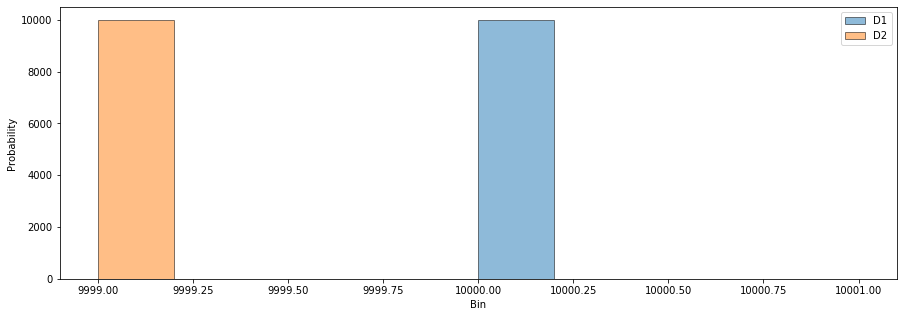

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', binsize = "unity", bound = False, exact = True)

If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10005.00640527369  Stdev fD1:  2.872289302860187  Mean fD2:  10003.992950500719  Stdev fD2:  2.887608362720967

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1074, pvalue=1.2941082951613566e-50) 

Wasserstein Distance:  2.9655172413793096 

DP Predicate Test: False 



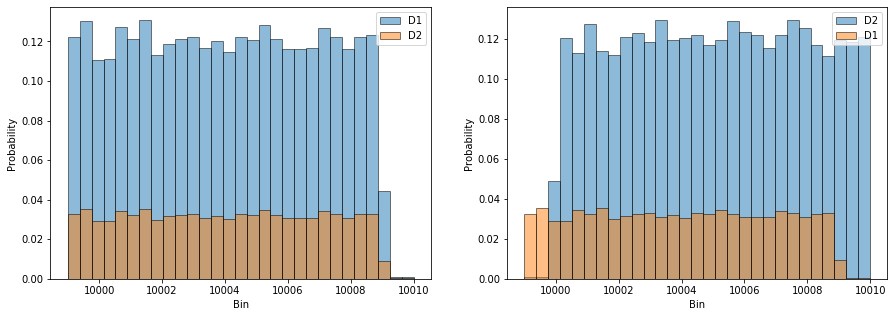

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False,bound = True)

#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.95480932162  Stdev fD1:  5.301563575745068  Mean fD2:  9998.998384731454  Stdev fD2:  5.3200400066447

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0784, pvalue=3.808765148627586e-27) 

Wasserstein Distance:  5.45679012345679 

DP Predicate Test: True 



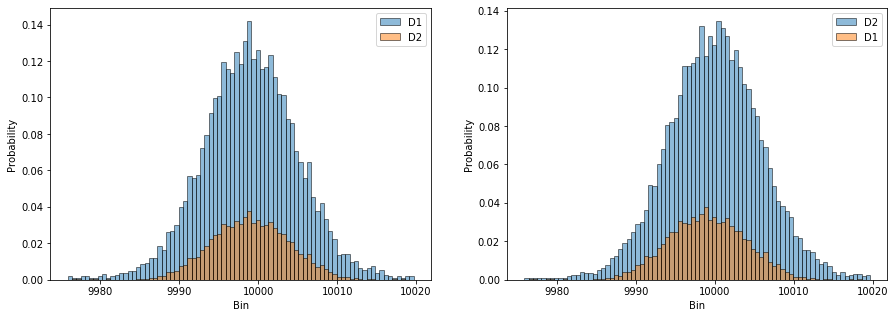

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.054263432346  Stdev fD1:  64.51719634087591  Mean fD2:  20009.962483381896  Stdev fD2:  63.84899576819309

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0275, pvalue=0.0010385517933069264) 

Wasserstein Distance:  4.070588235294117 

DP Predicate Test: True 



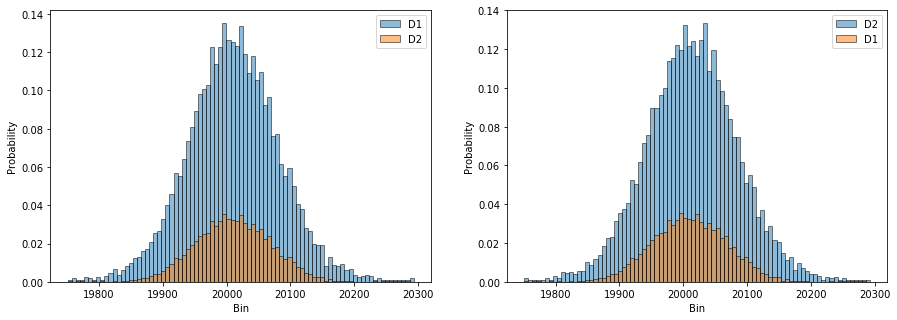

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.001271207718558  Stdev fD1:  0.0064890539614701785  Mean fD2:  2.001484926140308  Stdev fD2:  0.006470230589010468

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0165, pvalue=0.13138496726749369) 

Wasserstein Distance:  5.037974683544304 

DP Predicate Test: True 



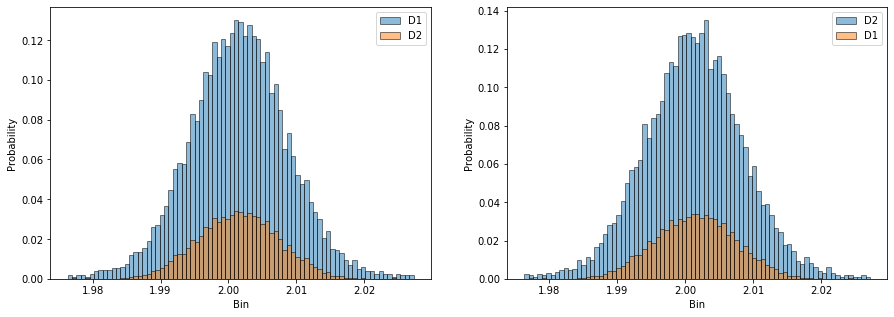

In [8]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', binsize="auto", debug=False, plot=True)

#### Noisy mean passes the DP Predicate test

### Variance Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.0518948383786015  Stdev fD1:  0.09250734414565505  Mean fD2:  2.051949471009194  Stdev fD2:  0.09405594151391301

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0137, pvalue=0.30504141099080584) 

Wasserstein Distance:  6.5352112676056375 

DP Predicate Test: True 



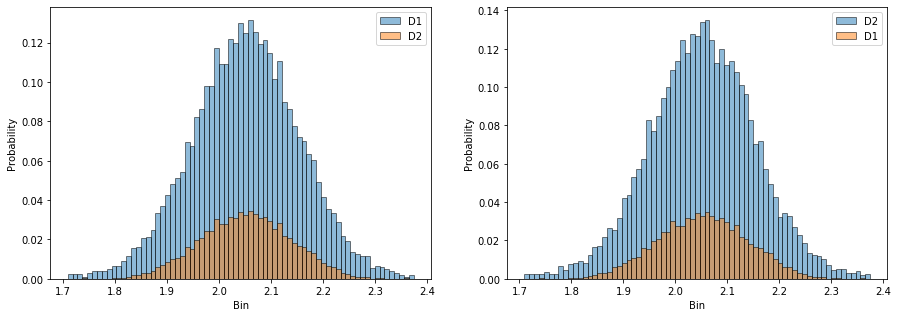

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', binsize="auto", debug=False)

#### Noisy variance passes the DP Predicate test

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.980325412766  Stdev fD1:  5.371379137621207  Mean fD2:  9999.031378543827  Stdev fD2:  5.288191355084051

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28) 

Wasserstein Distance:  4.951219512195123 

DP Predicate Test: True 



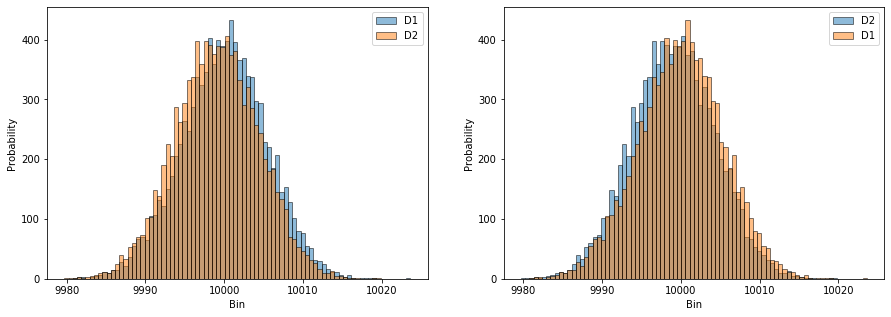

(True,
 Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28),
 4.951219512195123)

In [10]:
dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

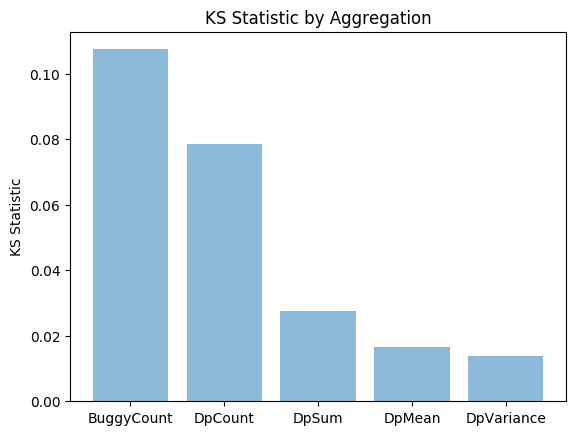

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

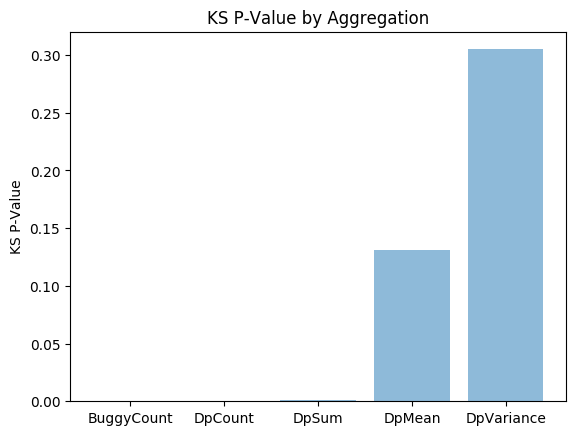

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

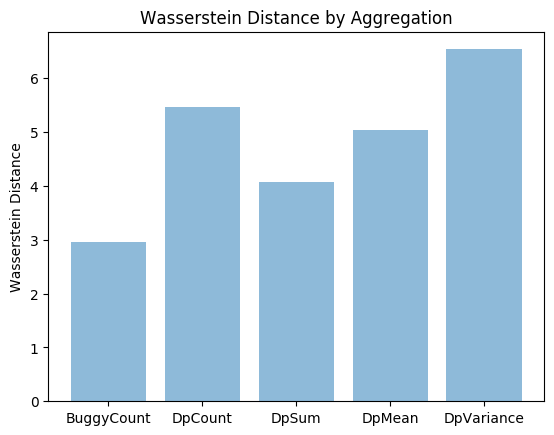

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [14]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.003150446026  Stdev fD1:  5.329548568121991  Mean fD2:  9999.068096604222  Stdev fD2:  5.345181279124184

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0682, pvalue=1.21976233733592e-20) 

Wasserstein Distance:  4.409638554216866 

DP Predicate Test: True 

--- 0.03907513618469238 seconds ---


In [15]:
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.521400350048  Stdev fD1:  64.33678728785993  Mean fD2:  20009.570909004782  Stdev fD2:  63.991294298451635

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0212, pvalue=0.022340230544746754) 

Wasserstein Distance:  5.788235294117644 

DP Predicate Test: True 

--- 0.046976566314697266 seconds ---


In [16]:
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.954461149271  Stdev fD1:  2.8988207643457353  Mean fD2:  10003.953225665098  Stdev fD2:  2.892072355511362

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1069, pvalue=3.793908925840325e-50) 

Wasserstein Distance:  4.689655172413794 

DP Predicate Test: False 

--- 0.049346208572387695 seconds ---


### Verifying Burdock Private Query Mechanism implementation

#### Laplace mechanism - COUNT

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.983825192772  Stdev fD1:  1.418534727691278  Mean fD2:  9998.982680911598  Stdev fD2:  1.4029026278616756

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.3983, pvalue=0.0) 

Wasserstein Distance:  3.027397260273972 

DP Predicate Test: True 



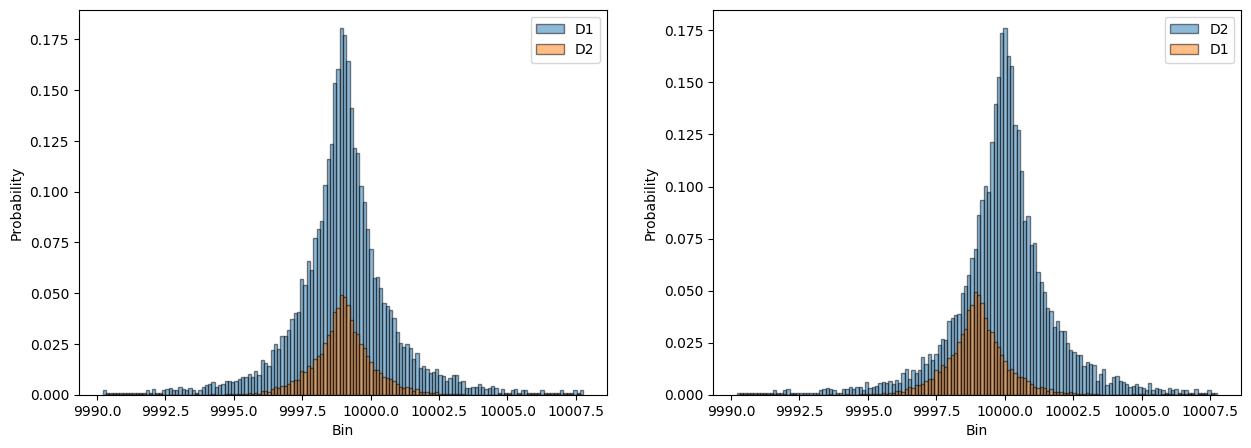

In [17]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Laplace mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.881273601895  Stdev fD1:  16.916823495934302  Mean fD2:  20010.157944666687  Stdev fD2:  16.735197479635485

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1158, pvalue=8.625311118337288e-59) 

Wasserstein Distance:  2.4761904761904745 

DP Predicate Test: True 



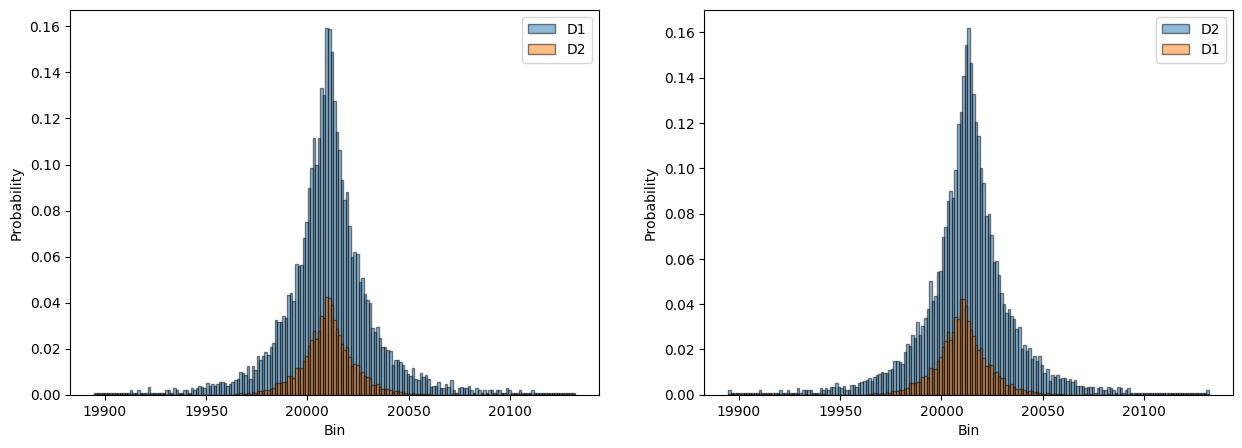

In [18]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

#### Gaussian mechanism - Count

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.79395692355  Stdev fD1:  8.619767592870543  Mean fD2:  9998.93995320258  Stdev fD2:  8.547732037824783

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0411, pvalue=9.187228212850023e-08) 

Wasserstein Distance:  4.894736842105262 

DP Predicate Test: True 



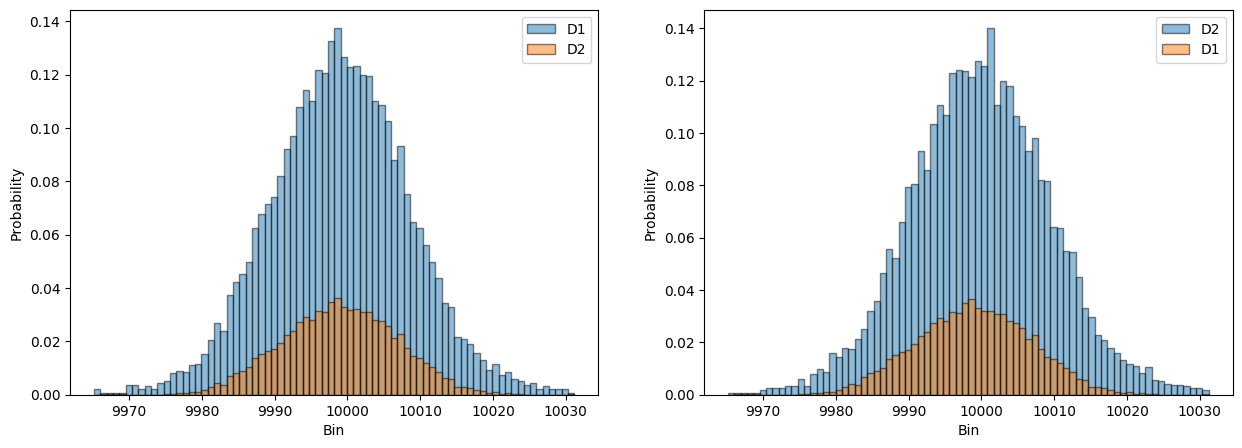

In [19]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Gaussian")
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Gaussian Mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.889955420756  Stdev fD1:  8.627042242948349  Mean fD2:  20012.13746550854  Stdev fD2:  8.767314466507102

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0416, pvalue=6.07449628840606e-08) 

Wasserstein Distance:  5.374999999999998 

DP Predicate Test: True 



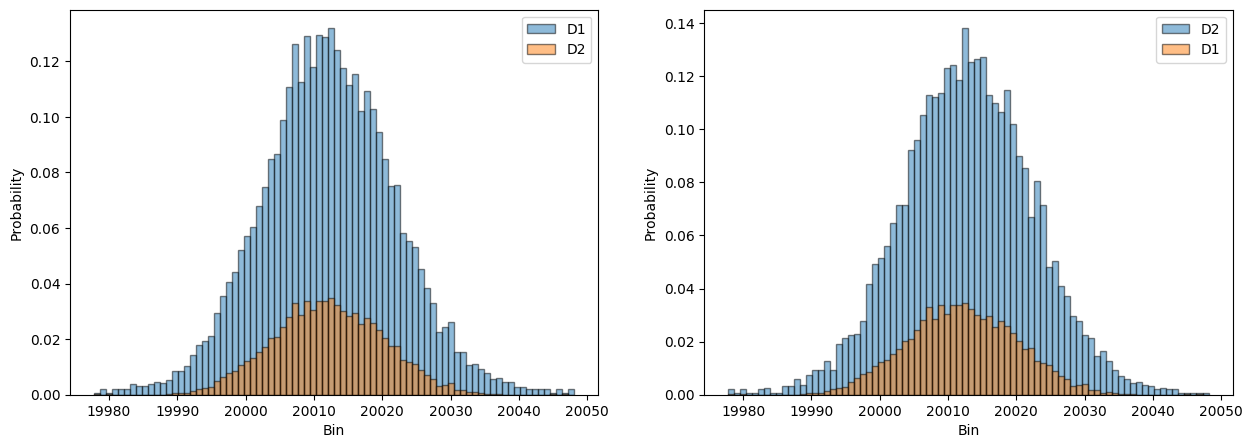

In [20]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

### Verifying Burdock Private Query implementation for a sample query

#### Note: Burdock uses Laplace noise by default right now but has support for both Laplace and Gaussian noise

### SUM DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  0.0009104082346474791
p-Value of 1 sample t-test:  0.006355766963731154


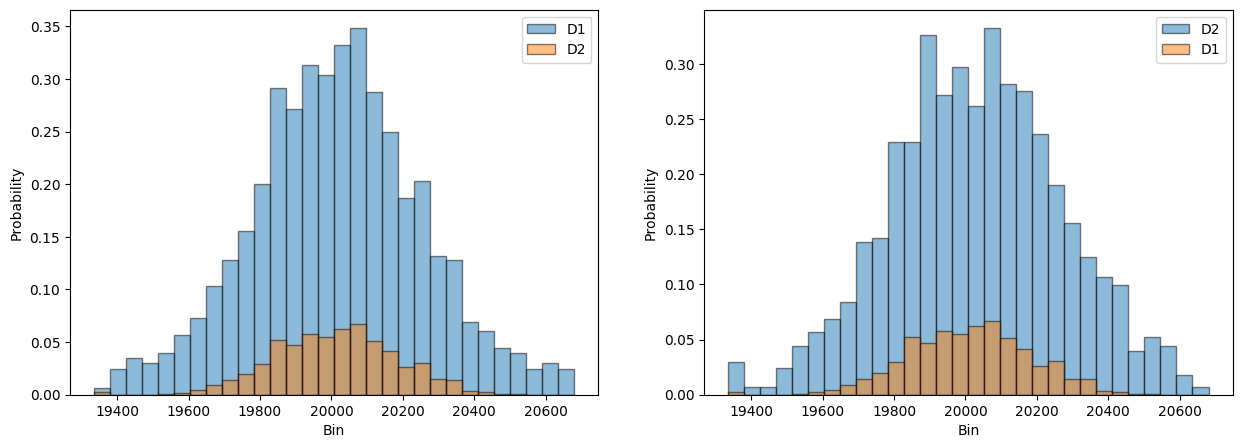

DP Predicate Test:  True
Bias Test:  True
--- 29.95975923538208 seconds ---


In [21]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Laplace")
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT SUM(Usage) AS TotalUsage FROM d1.d1"
d2_query = "SELECT SUM(Usage) AS TotalUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### COUNT DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  -5.4600000000000006e-05
p-Value of 1 sample t-test:  0.03789468939535141


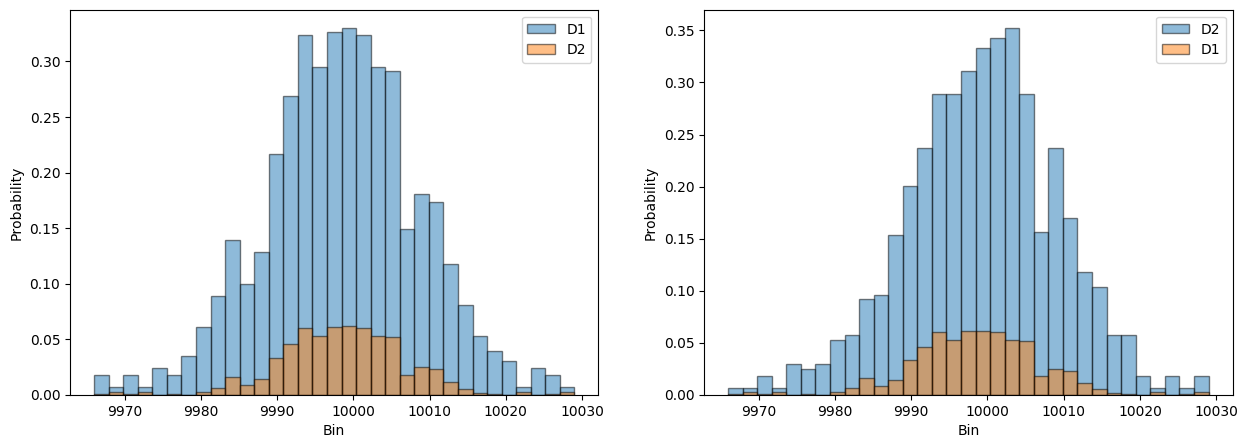

DP Predicate Test:  True
Bias Test:  True
--- 21.542136192321777 seconds ---


In [22]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### MEAN DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  0.00013212903819746468
p-Value of 1 sample t-test:  0.6959550021401922


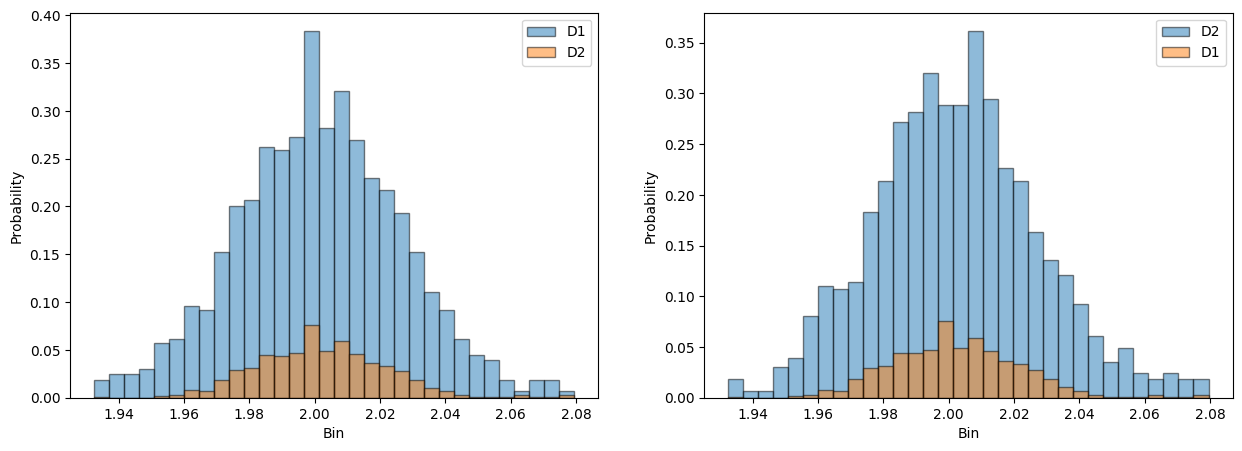

DP Predicate Test:  True
Bias Test:  False
--- 23.5754554271698 seconds ---


In [23]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT AVG(Usage) AS AvgUsage FROM d1.d1"
d2_query = "SELECT AVG(Usage) AS AvgUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### Powerset Test

Test case:  [0.0, -333.33333333333337, -600.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.21566806054463078
p-Value of 1 sample t-test:  0.5640184419737438
DP Predicate Test Result:  True


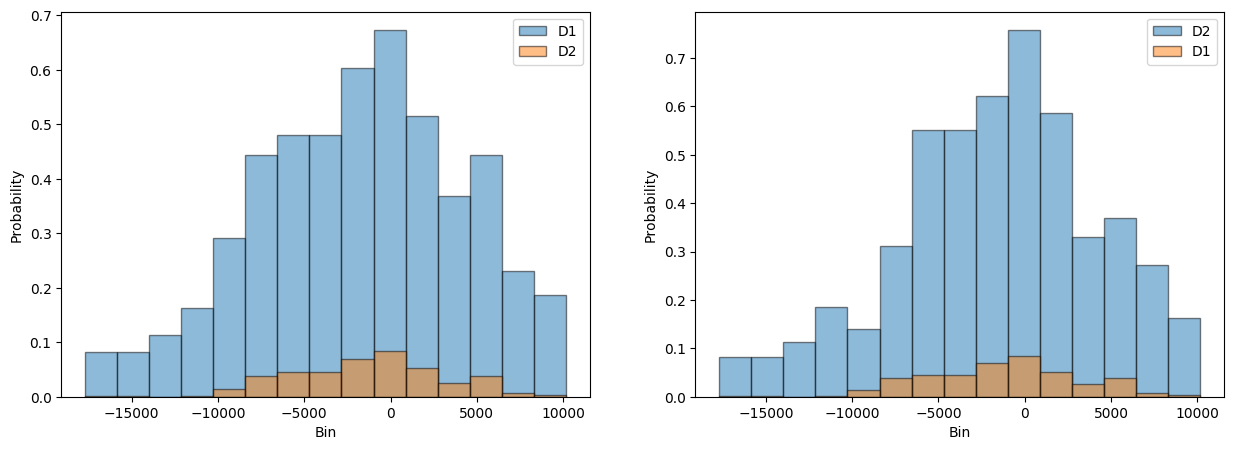

Testing:  12_1
Mean signed deviation ratio to actual:  -0.26251561627666165
p-Value of 1 sample t-test:  0.45999700076746364
DP Predicate Test Result:  True


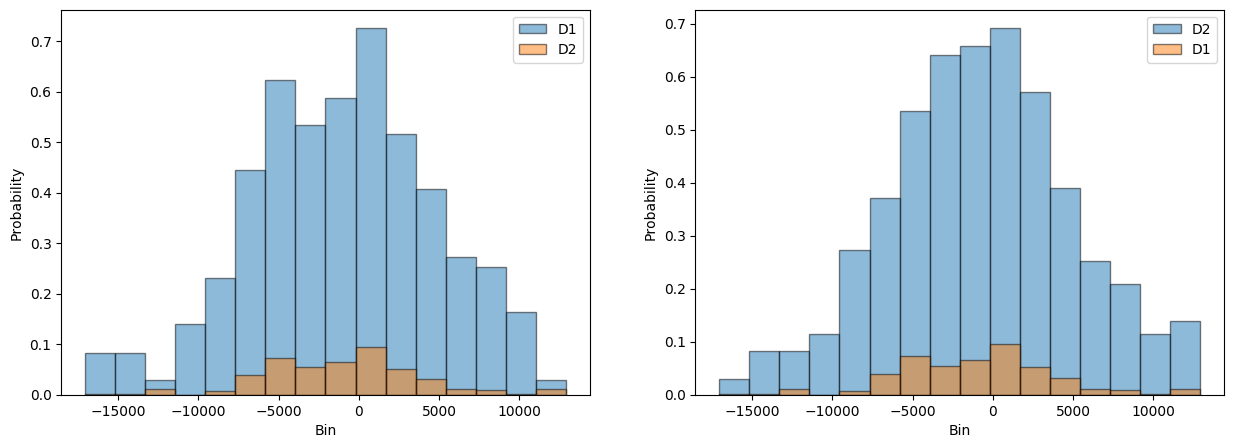

Testing:  2_2
Mean signed deviation ratio to actual:  -0.42414906390930845
p-Value of 1 sample t-test:  0.4531158440378833
DP Predicate Test Result:  True


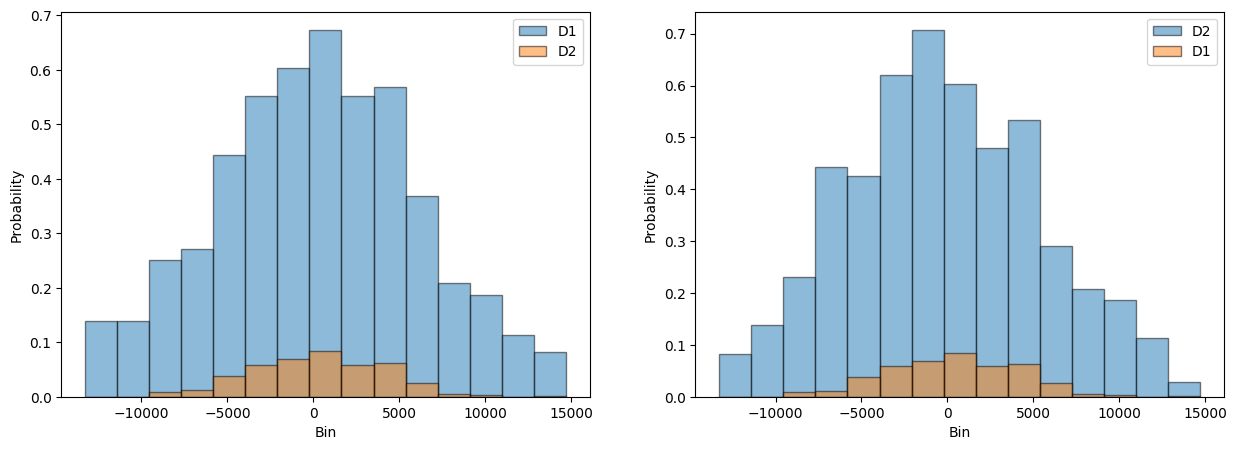

Testing:  12_2
Mean signed deviation ratio to actual:  0.5668594730230889
p-Value of 1 sample t-test:  0.17730983880213724
DP Predicate Test Result:  True


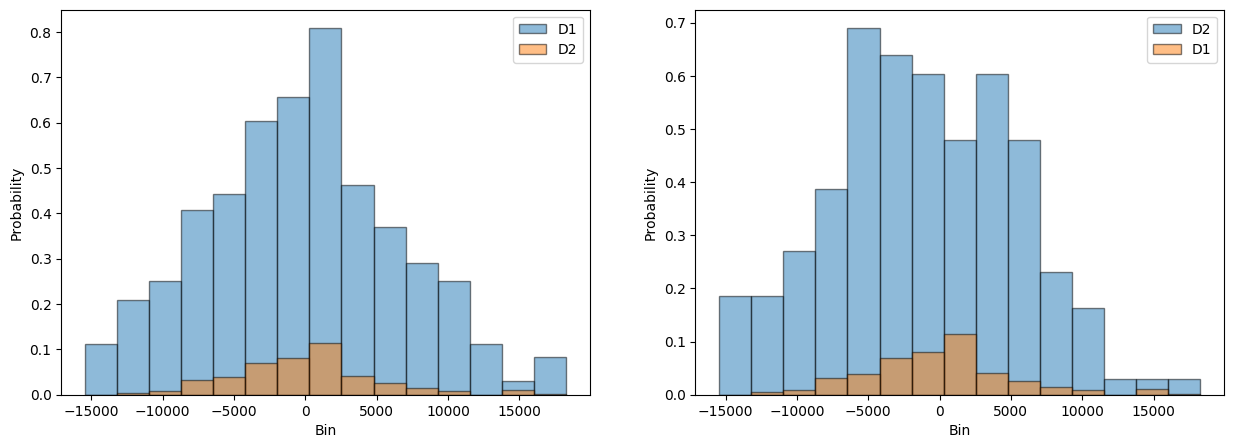

Testing:  1_1
Mean signed deviation ratio to actual:  -1.7401791674489753
p-Value of 1 sample t-test:  0.002740096980022883
DP Predicate Test Result:  True


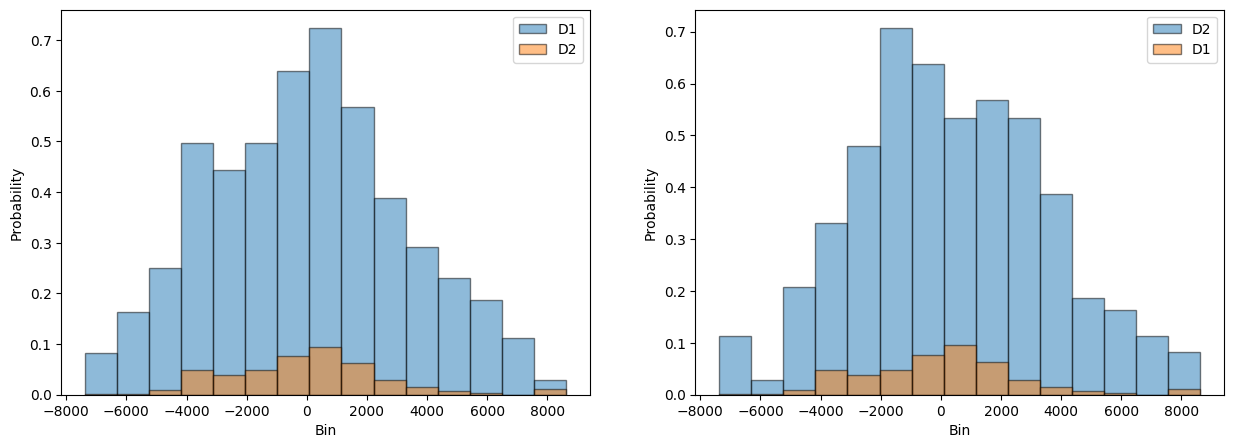

Testing:  012_1
Mean signed deviation ratio to actual:  0.2588548374668051
p-Value of 1 sample t-test:  0.501719248860256
DP Predicate Test Result:  True


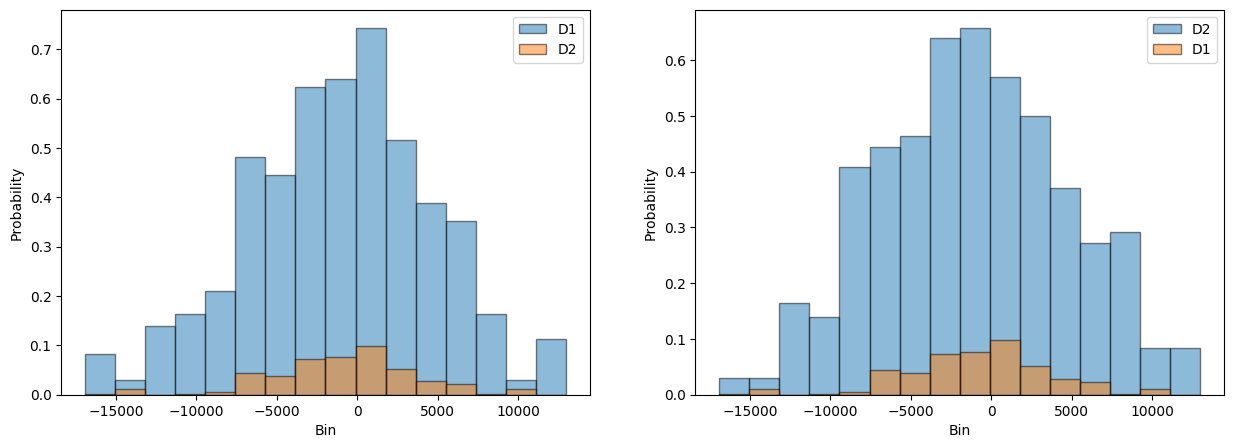

Testing:  02_0
Mean signed deviation ratio to actual:  -0.0018032214704960703
p-Value of 1 sample t-test:  0.9975022631262582
DP Predicate Test Result:  True


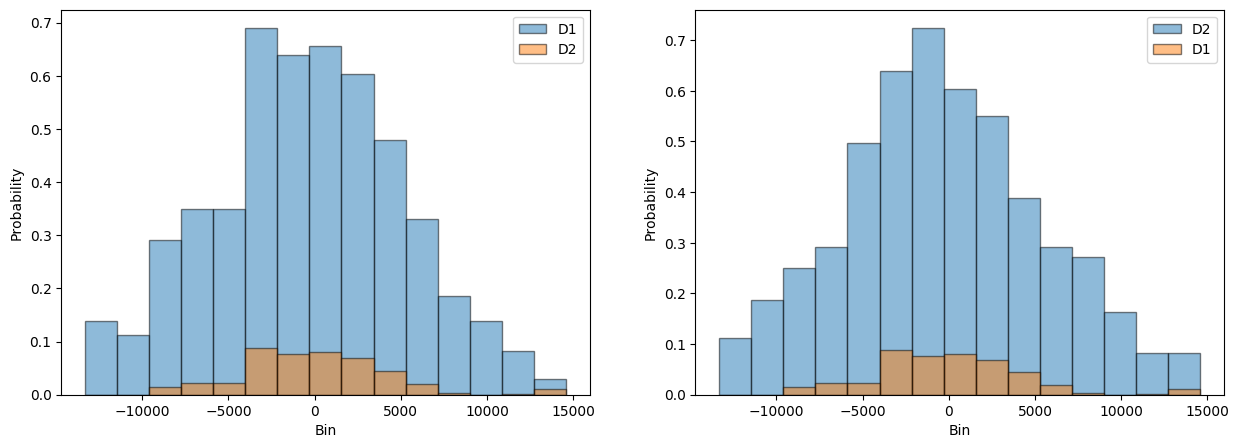

Testing:  02_2
Mean signed deviation ratio to actual:  -0.33280910437226774
p-Value of 1 sample t-test:  0.5550080260409012
DP Predicate Test Result:  True


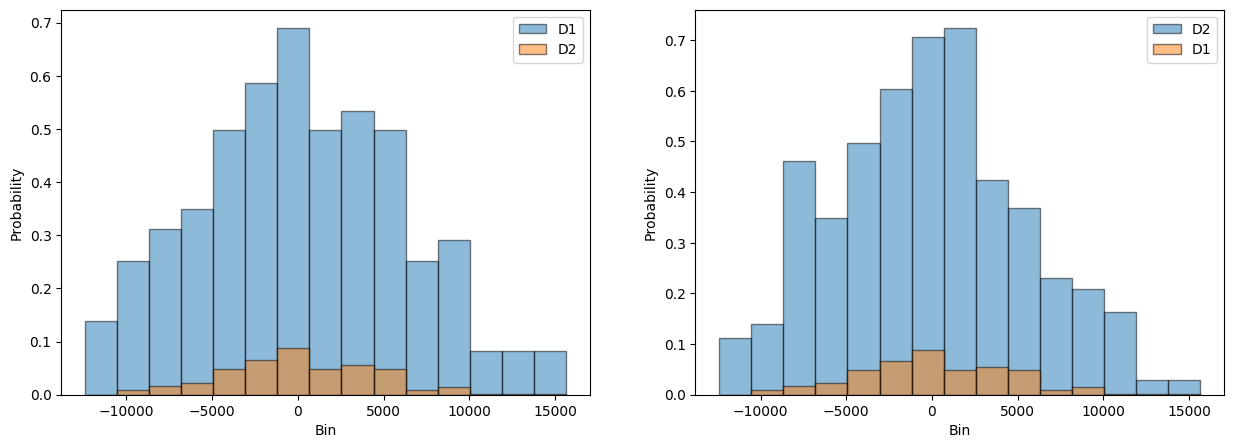

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


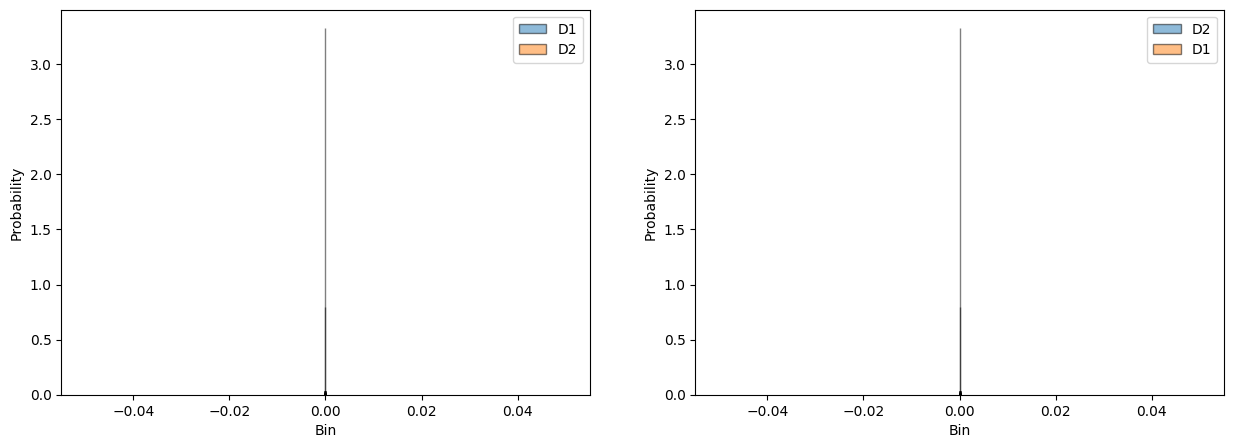

Testing:  012_2
Mean signed deviation ratio to actual:  -0.3615962942936705
p-Value of 1 sample t-test:  0.35272174982204585
DP Predicate Test Result:  True


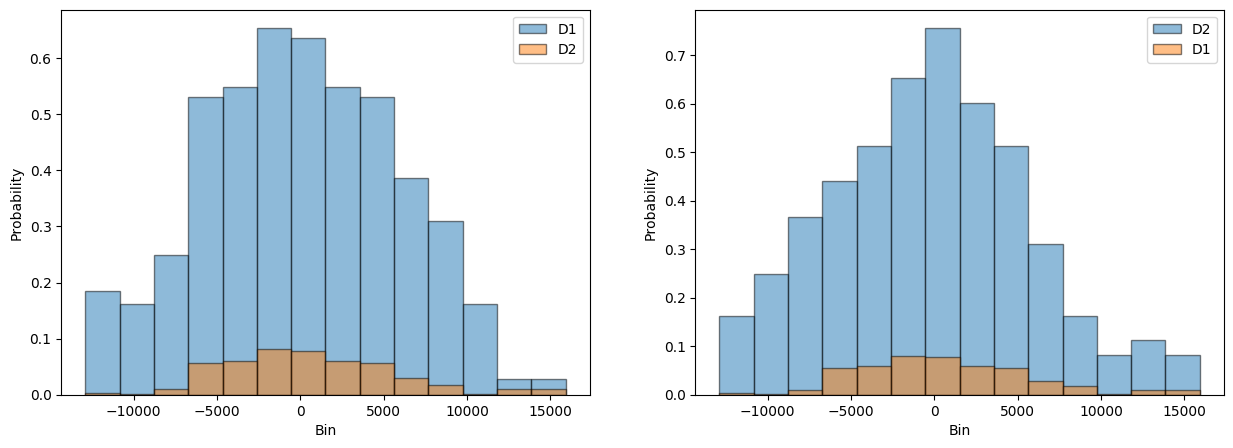

Testing:  01_0
Mean signed deviation ratio to actual:  1.0095045099211044
p-Value of 1 sample t-test:  0.0753530102889193
DP Predicate Test Result:  True


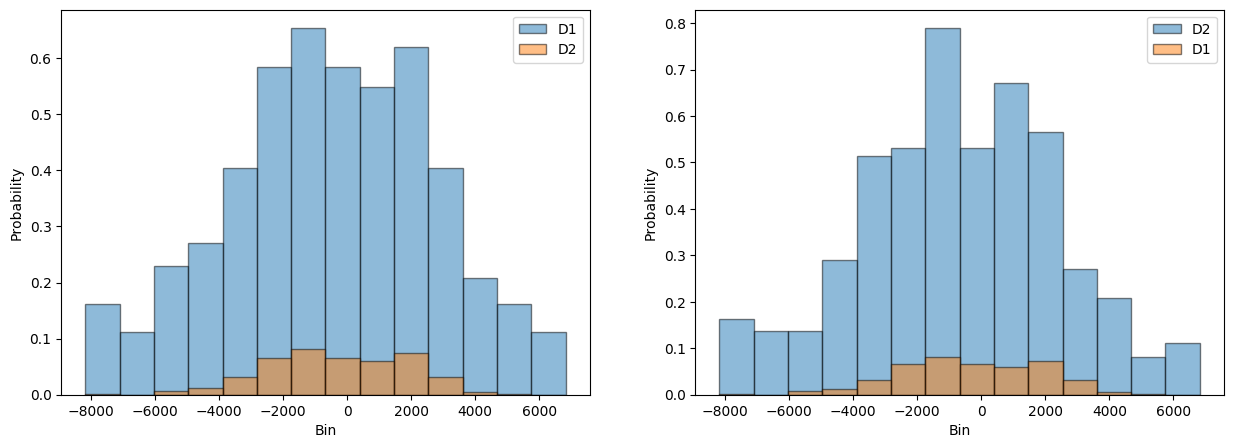

Testing:  01_1
Mean signed deviation ratio to actual:  -0.8399422690918686
p-Value of 1 sample t-test:  0.19336519850759065
DP Predicate Test Result:  True


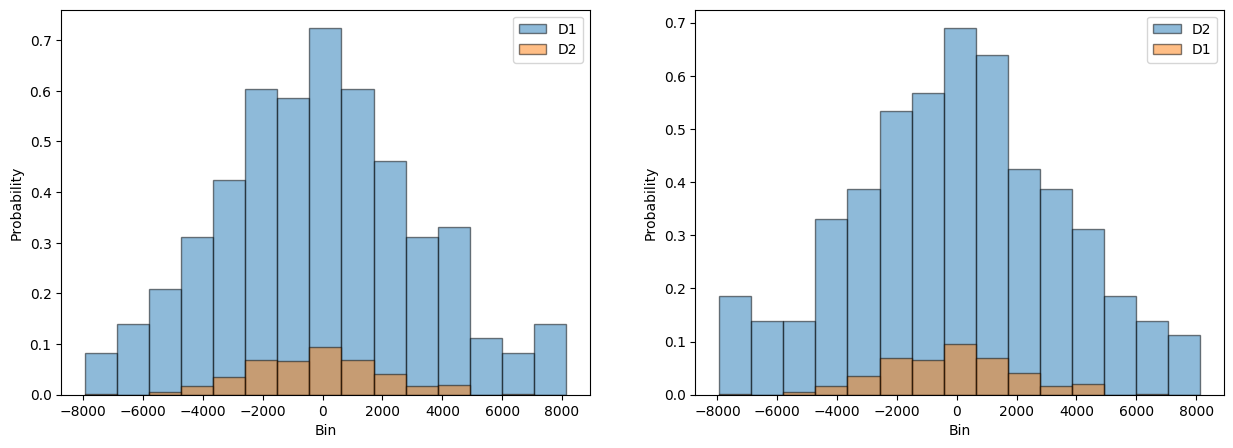

Test case:  [-500.0, 333.33333333333326, -200.0]
Testing:  012_0
Mean signed deviation ratio to actual:  -0.2811893015214984
p-Value of 1 sample t-test:  0.45041346066332755
DP Predicate Test Result:  True


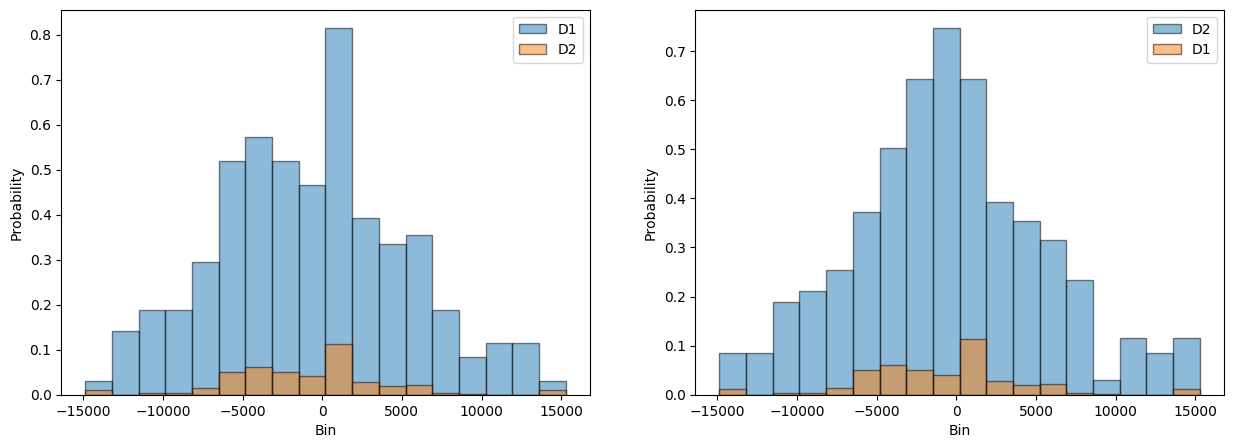

Testing:  12_1
Mean signed deviation ratio to actual:  -0.8337284402193439
p-Value of 1 sample t-test:  0.025891340025525886
DP Predicate Test Result:  True


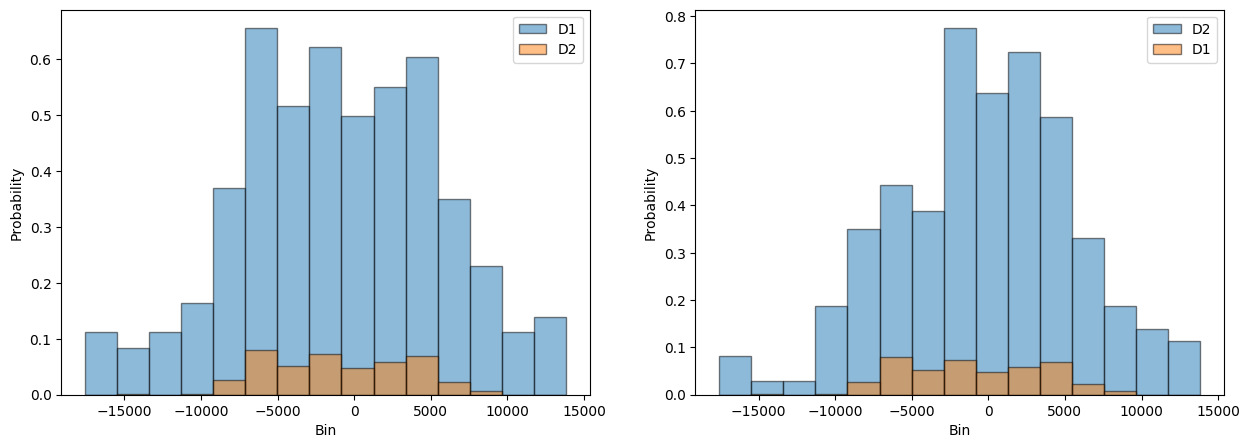

Testing:  2_2
Mean signed deviation ratio to actual:  0.36108633889634306
p-Value of 1 sample t-test:  0.5531913569030802
DP Predicate Test Result:  True


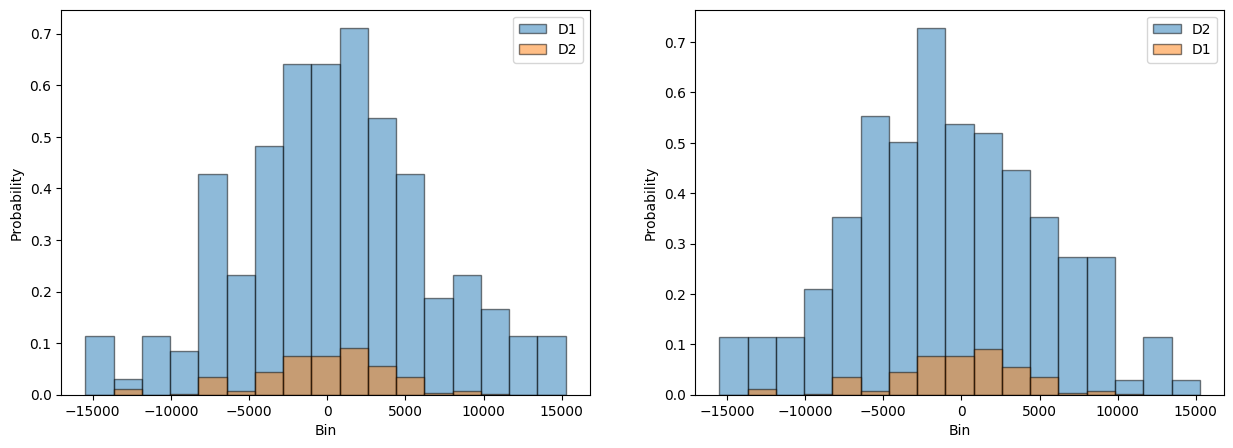

Testing:  12_2
Mean signed deviation ratio to actual:  -0.4632929287506042
p-Value of 1 sample t-test:  0.2432891756082405
DP Predicate Test Result:  True


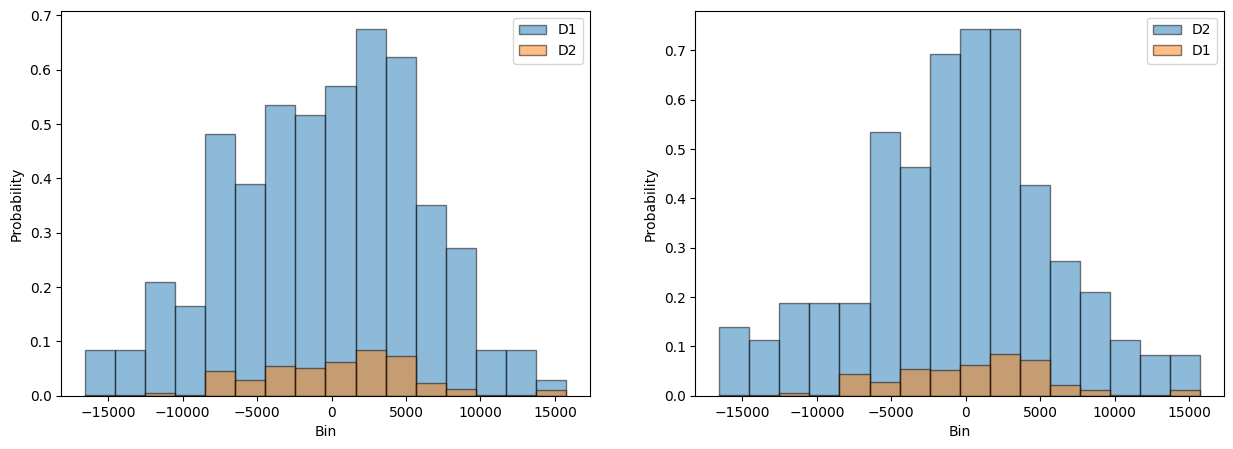

Testing:  1_1
Mean signed deviation ratio to actual:  -0.27939884495620443
p-Value of 1 sample t-test:  0.6256577206374236
DP Predicate Test Result:  True


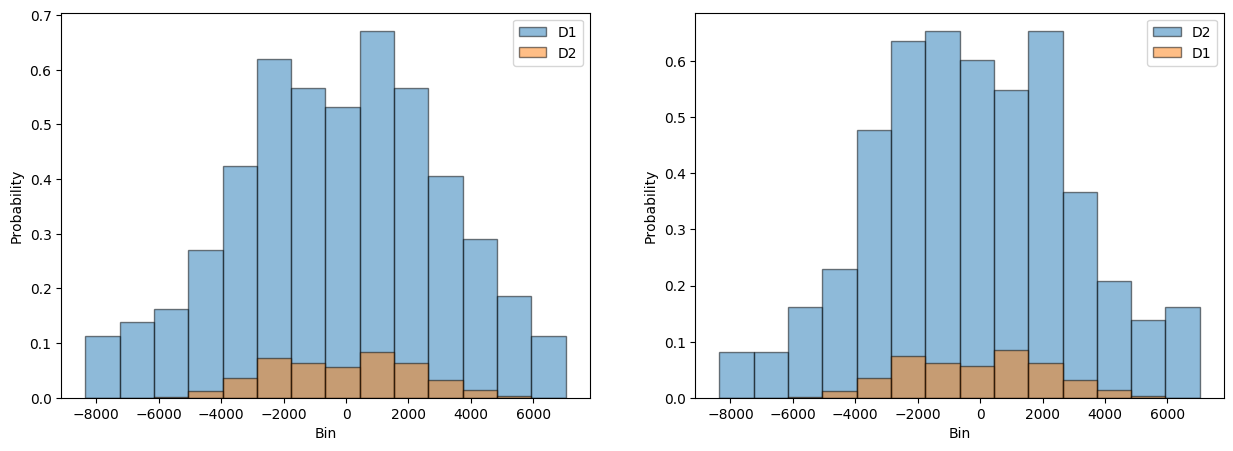

Testing:  012_1
Mean signed deviation ratio to actual:  -0.02851553114299121
p-Value of 1 sample t-test:  0.9384475917587034
DP Predicate Test Result:  True


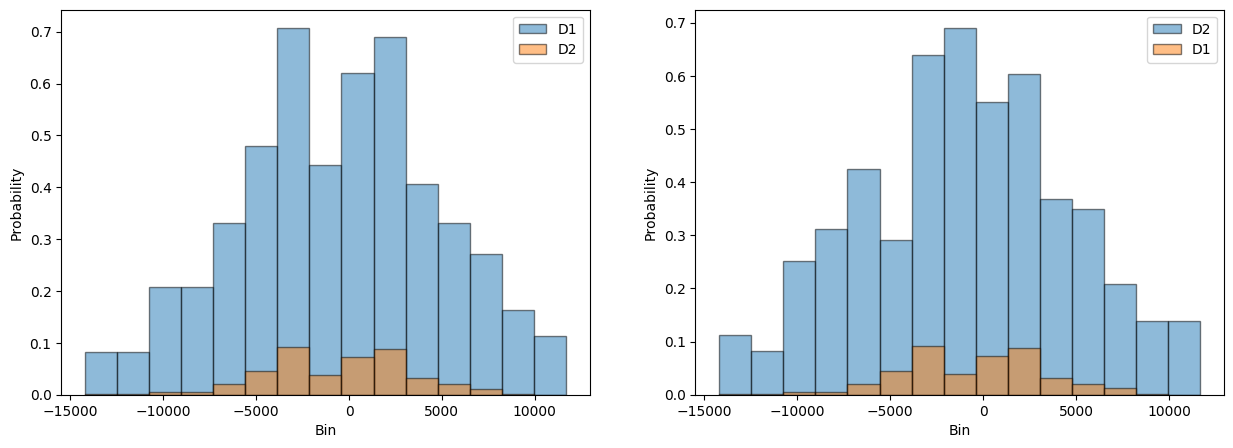

Testing:  02_0
Mean signed deviation ratio to actual:  0.07725798613673386
p-Value of 1 sample t-test:  0.890167371732501
DP Predicate Test Result:  True


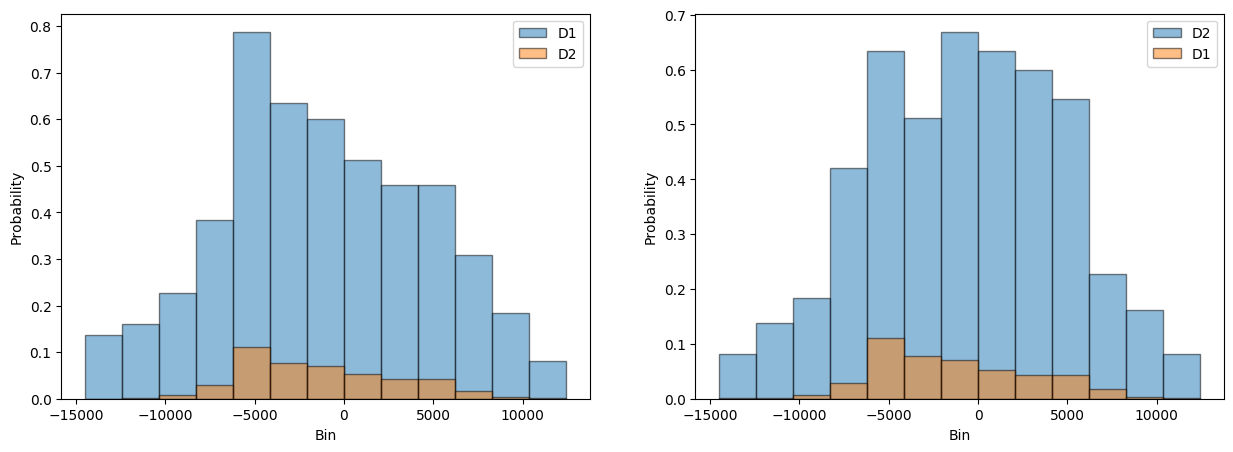

Testing:  02_2
Mean signed deviation ratio to actual:  0.48013095041637094
p-Value of 1 sample t-test:  0.41398075871887274
DP Predicate Test Result:  True


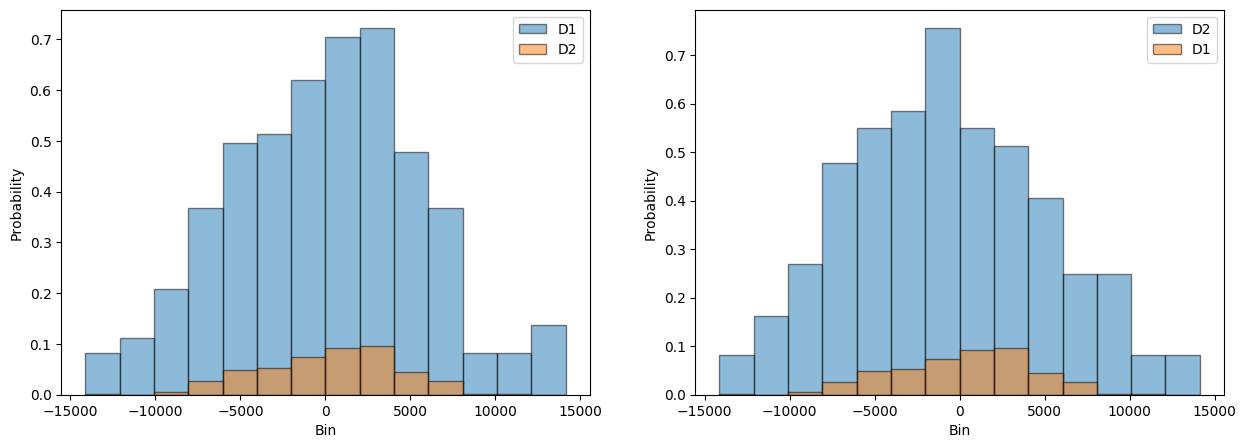

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


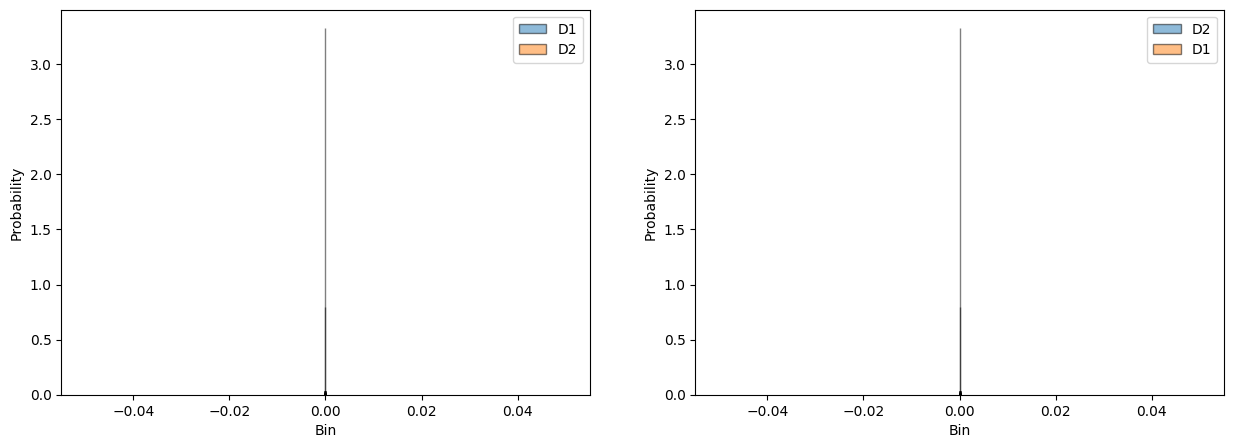

Testing:  012_2
Mean signed deviation ratio to actual:  -1.0372665699575516
p-Value of 1 sample t-test:  0.009364334725140346
DP Predicate Test Result:  True


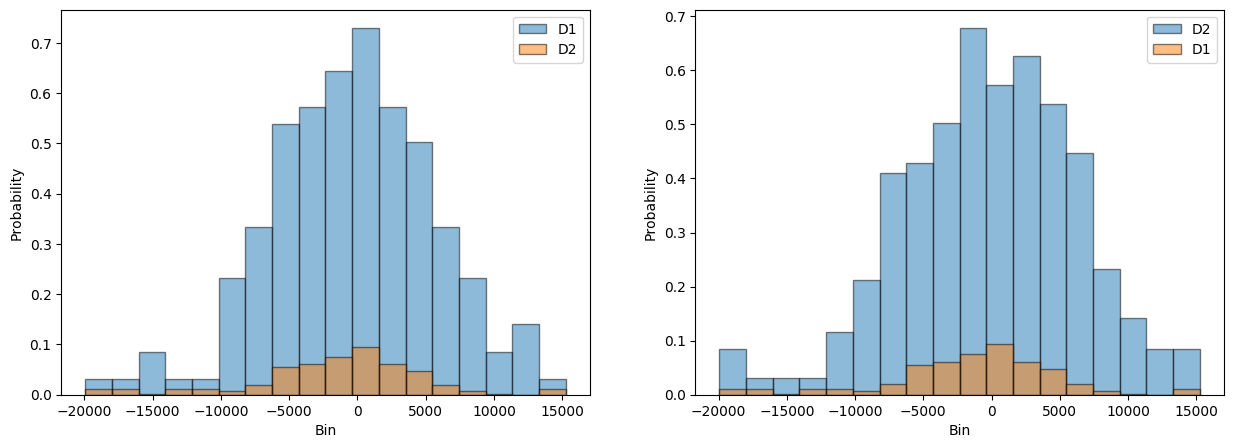

Testing:  01_0
Mean signed deviation ratio to actual:  -0.49268186973163786
p-Value of 1 sample t-test:  0.3963674874679668
DP Predicate Test Result:  True


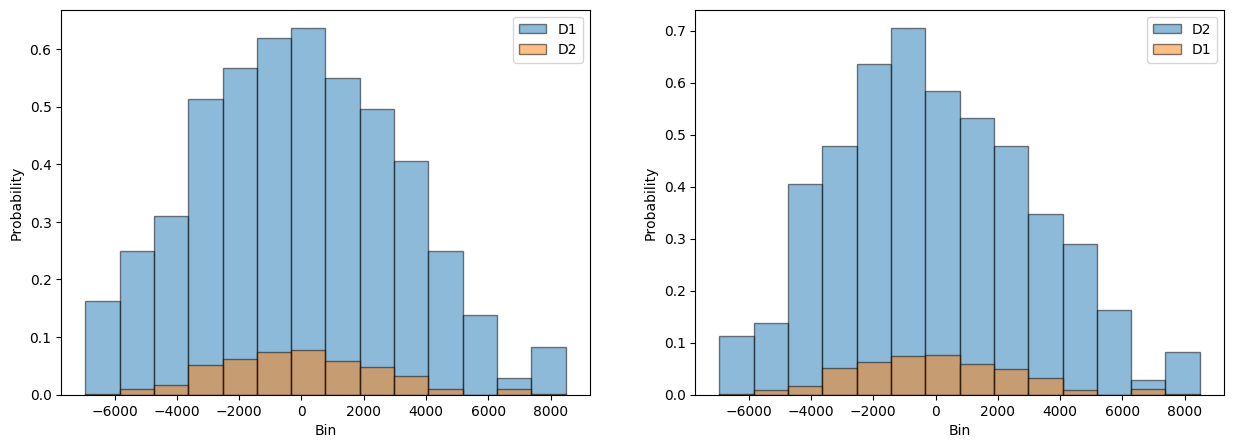

Testing:  01_1
Mean signed deviation ratio to actual:  -0.3961161087346582
p-Value of 1 sample t-test:  0.5277554524814324
DP Predicate Test Result:  True


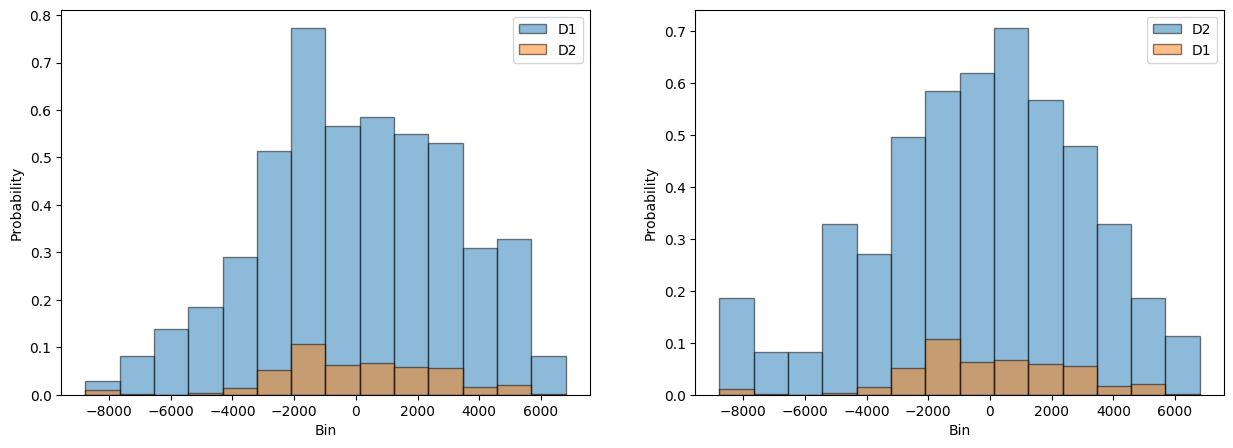

Test case:  [500.0, -777.7777777777778, 200.0]
Testing:  012_0
Mean signed deviation ratio to actual:  -0.4257625628688052
p-Value of 1 sample t-test:  0.2630405888042813
DP Predicate Test Result:  True


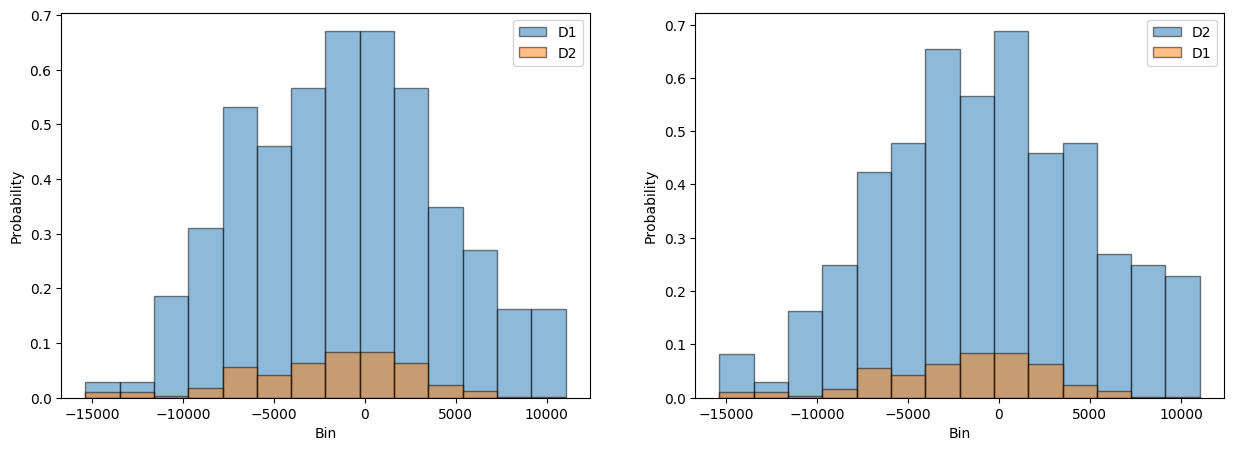

Testing:  12_1
Mean signed deviation ratio to actual:  0.34954068966495366
p-Value of 1 sample t-test:  0.3656742826265913
DP Predicate Test Result:  True


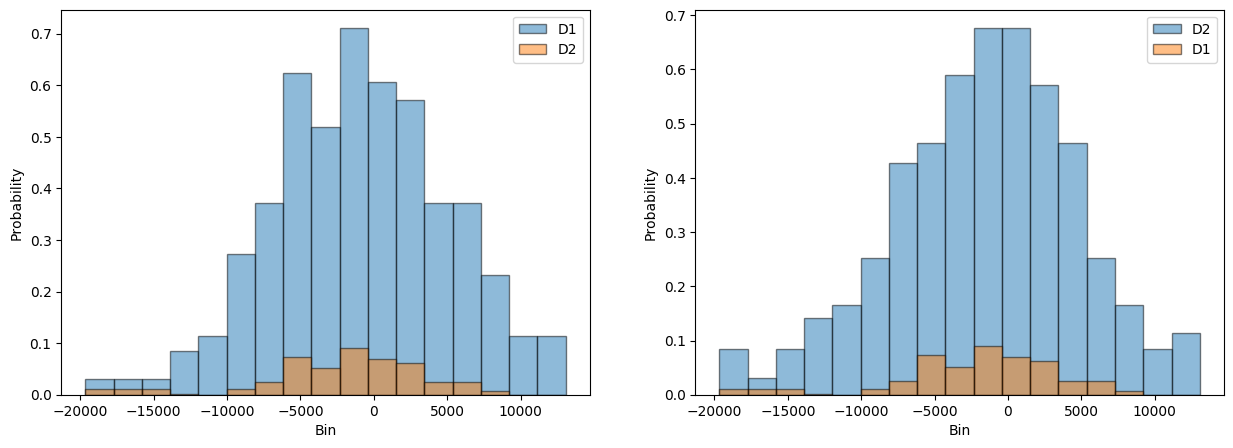

Testing:  2_2
Mean signed deviation ratio to actual:  -0.7556624417740124
p-Value of 1 sample t-test:  0.21161146702418998
DP Predicate Test Result:  True


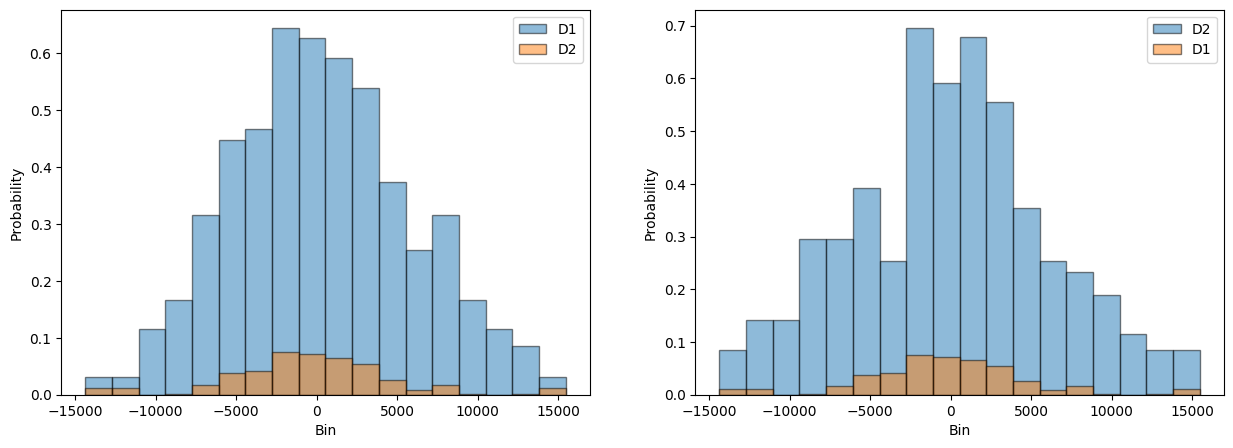

Testing:  12_2
Mean signed deviation ratio to actual:  0.7631037544277377
p-Value of 1 sample t-test:  0.057347226713716434
DP Predicate Test Result:  True


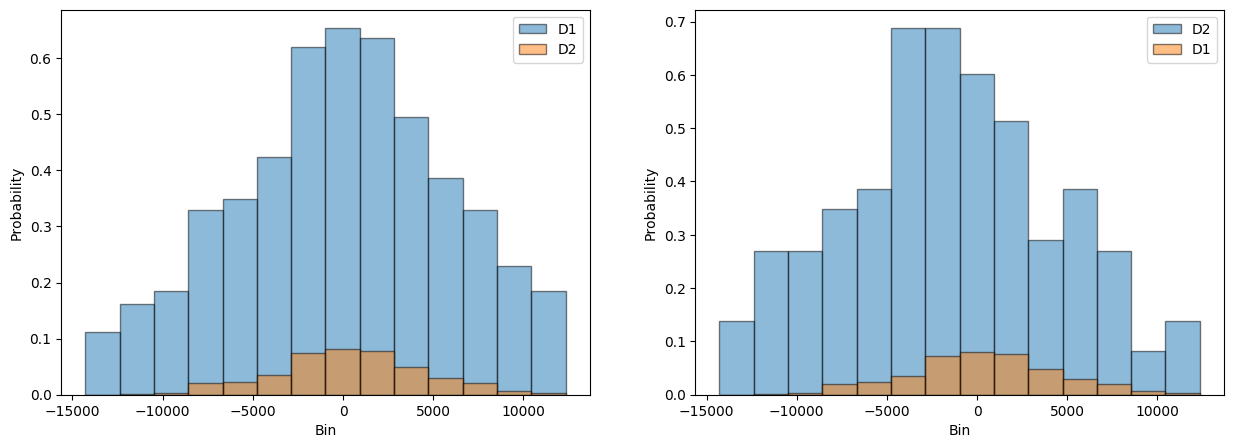

Testing:  1_1
Mean signed deviation ratio to actual:  -1.6276586726535238
p-Value of 1 sample t-test:  0.00878722168297686
DP Predicate Test Result:  True


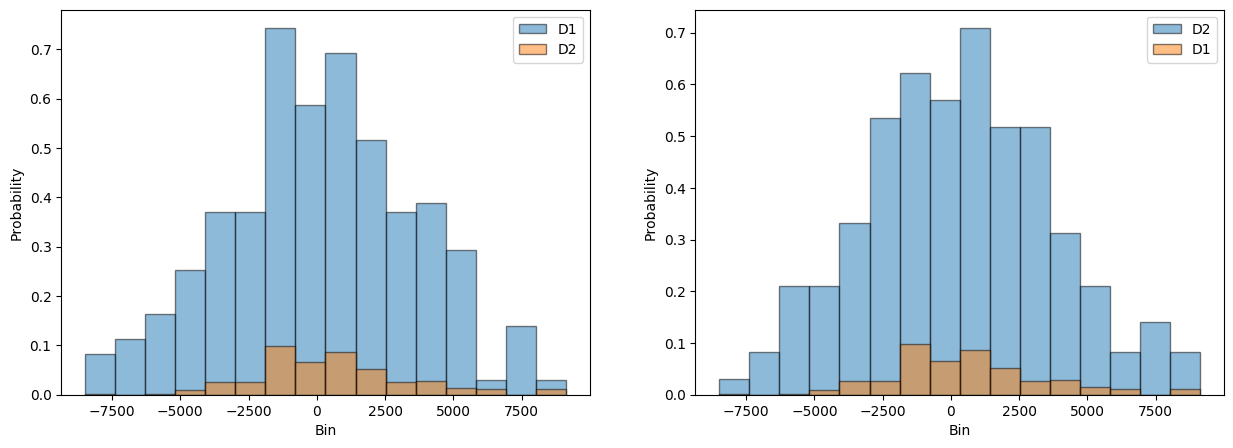

Testing:  012_1
Mean signed deviation ratio to actual:  0.24794199448362542
p-Value of 1 sample t-test:  0.5093067947020171
DP Predicate Test Result:  True


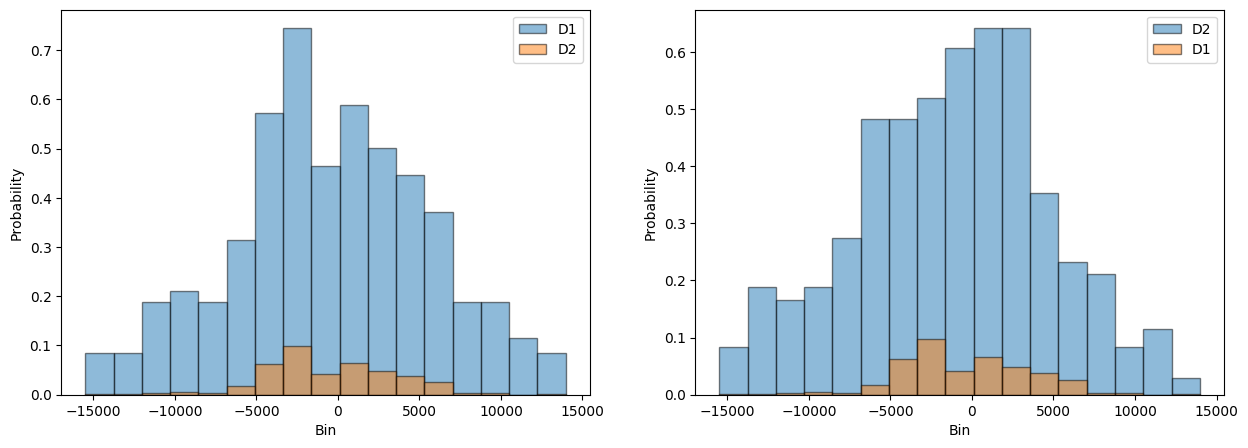

Testing:  02_0
Mean signed deviation ratio to actual:  -0.5104159210537731
p-Value of 1 sample t-test:  0.4012930050868315
DP Predicate Test Result:  True


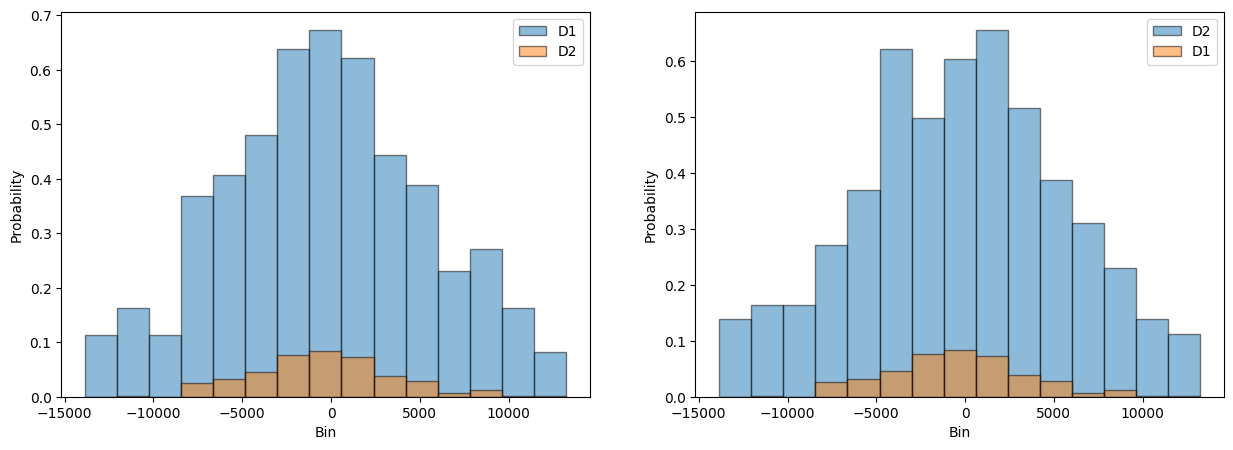

Testing:  02_2
Mean signed deviation ratio to actual:  0.07991188376735943
p-Value of 1 sample t-test:  0.8965583728743969
DP Predicate Test Result:  True


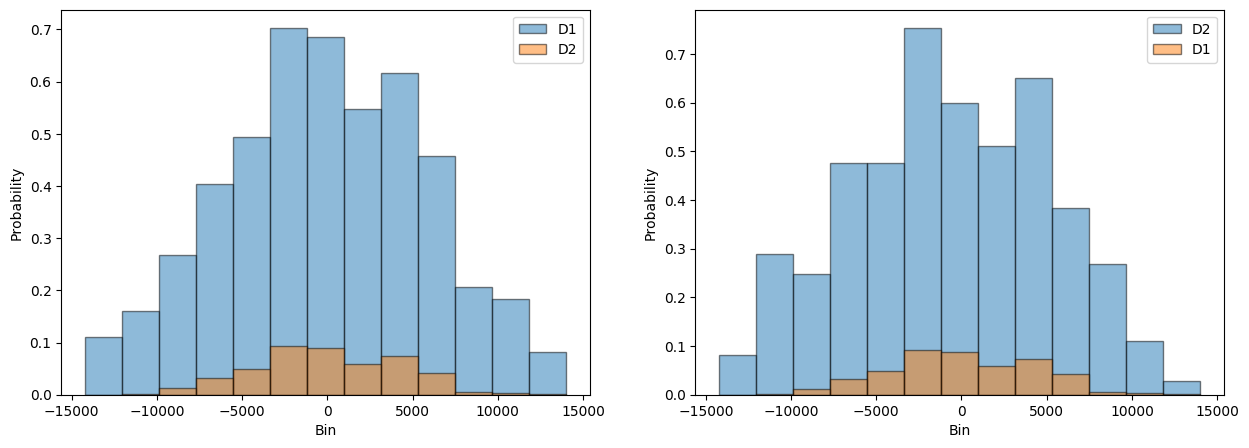

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


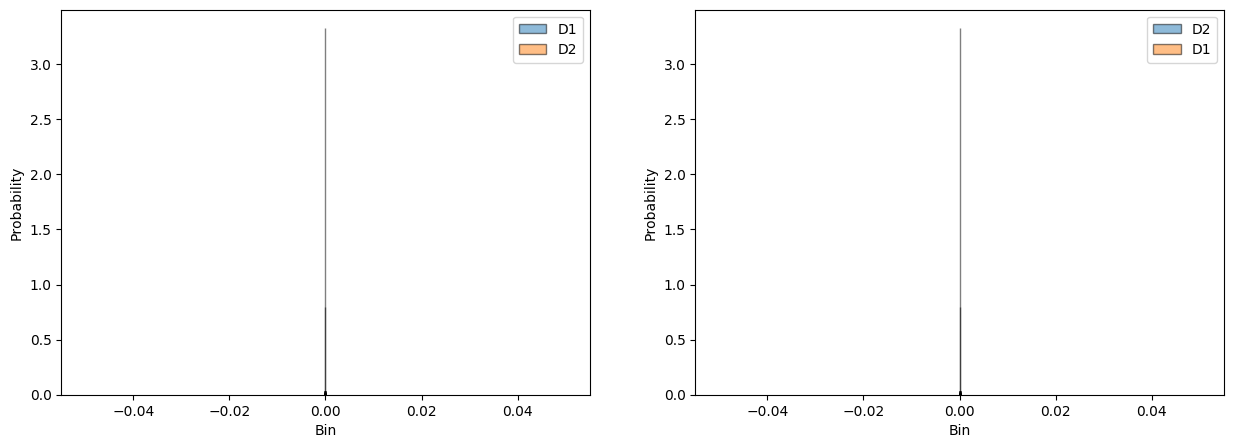

Testing:  012_2
Mean signed deviation ratio to actual:  0.24290763285533395
p-Value of 1 sample t-test:  0.4984175593051976
DP Predicate Test Result:  True


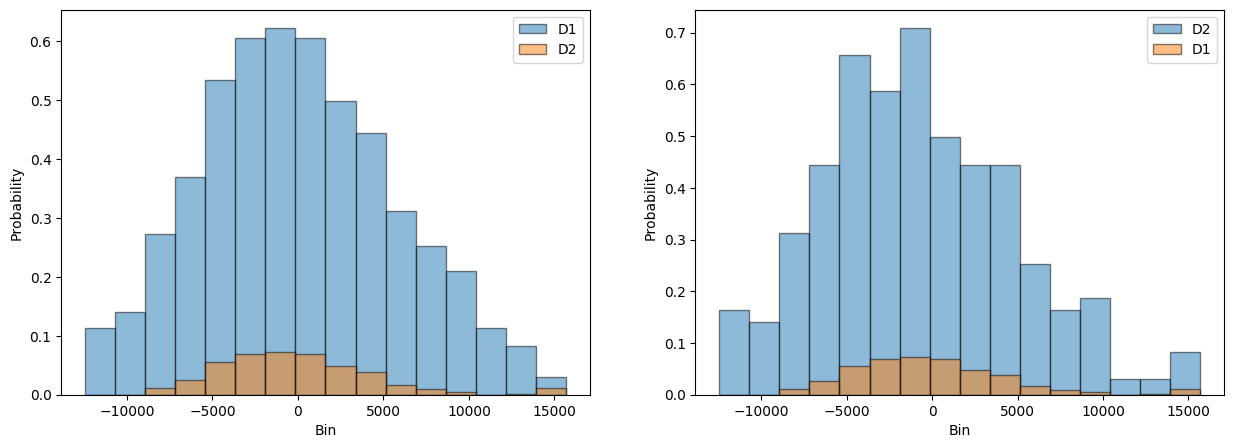

Testing:  01_0
Mean signed deviation ratio to actual:  -0.02565471311135381
p-Value of 1 sample t-test:  0.9676176408985024
DP Predicate Test Result:  True


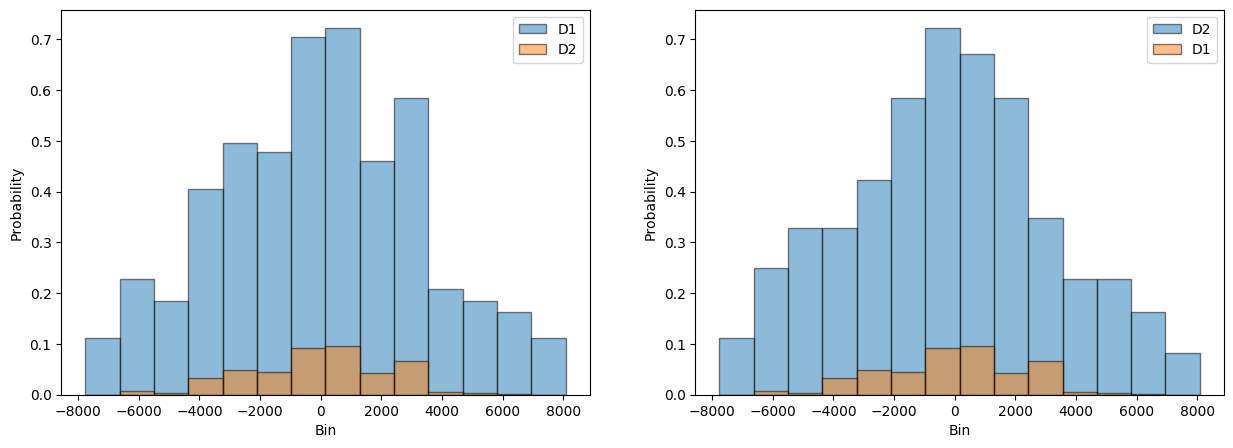

Testing:  01_1
Mean signed deviation ratio to actual:  0.17352792322403282
p-Value of 1 sample t-test:  0.761890858309332
DP Predicate Test Result:  True


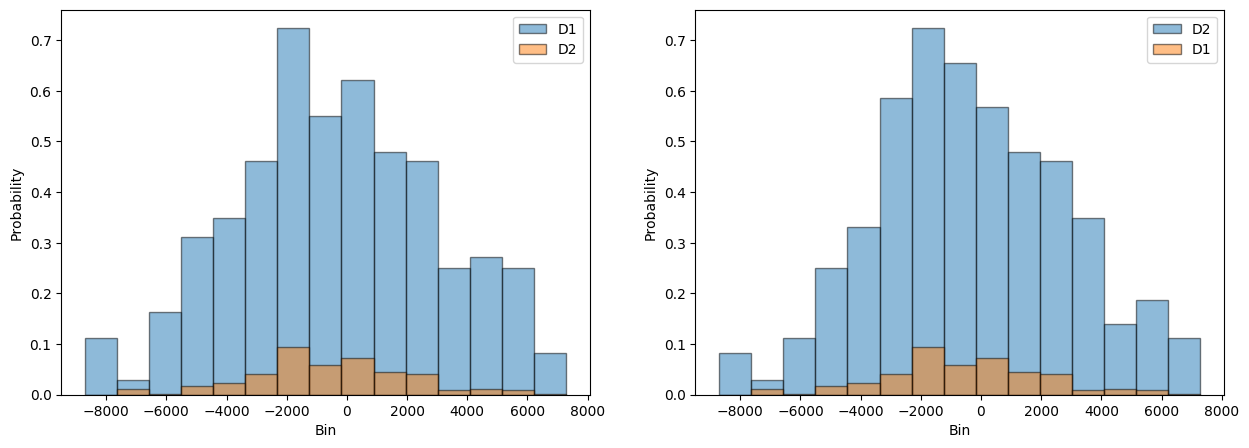

Test case:  [-750.0, -111.1111111111112, 600.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.7386350786820255
p-Value of 1 sample t-test:  0.06375898783884762
DP Predicate Test Result:  True


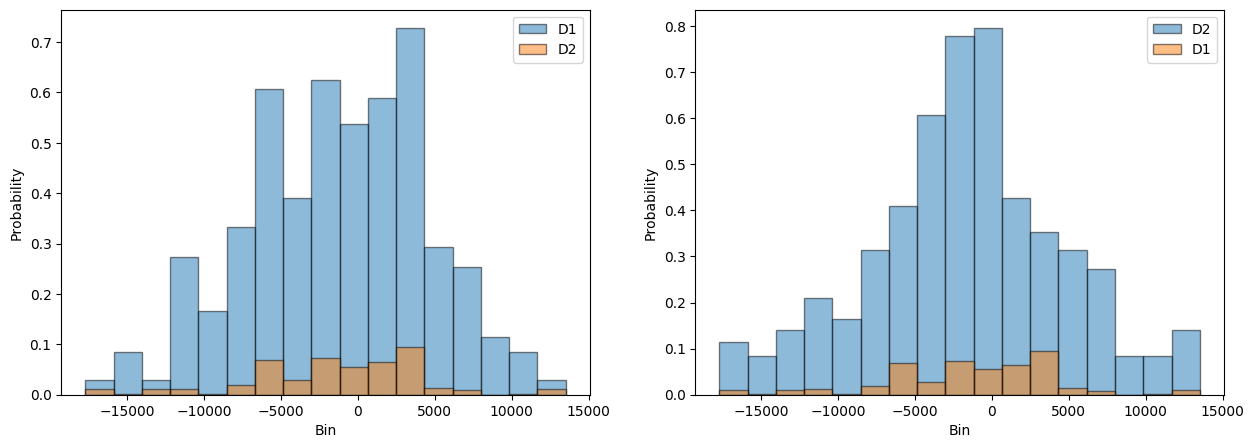

Testing:  12_1
Mean signed deviation ratio to actual:  -0.25714124170664887
p-Value of 1 sample t-test:  0.48077441587646563
DP Predicate Test Result:  True


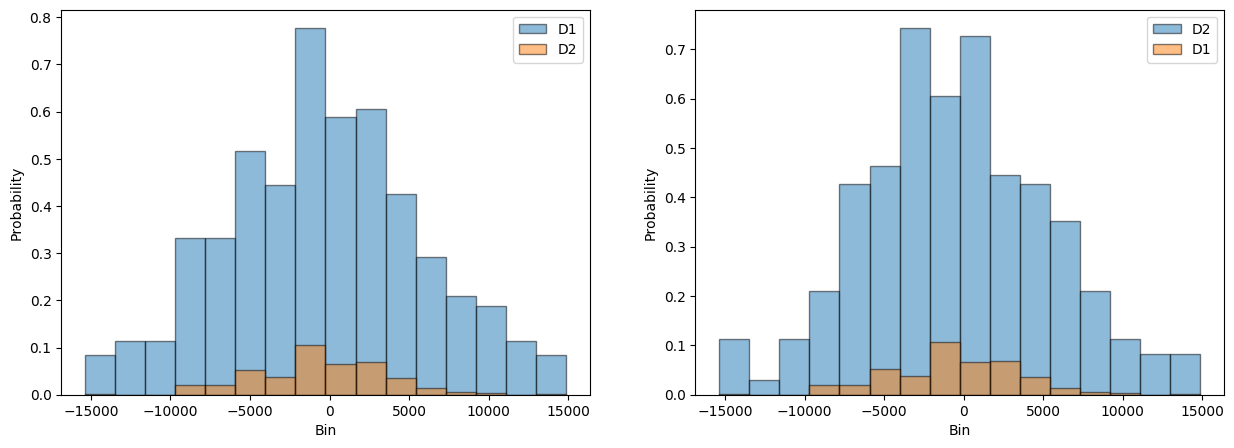

Testing:  2_2
Mean signed deviation ratio to actual:  -0.4391717731215085
p-Value of 1 sample t-test:  0.48165189623926974
DP Predicate Test Result:  True


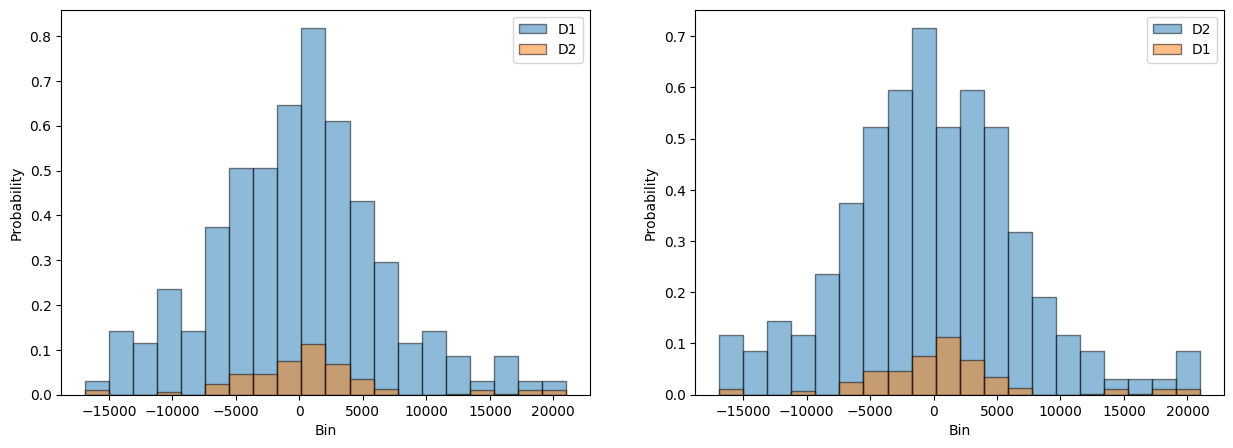

Testing:  12_2
Mean signed deviation ratio to actual:  0.7141816612838416
p-Value of 1 sample t-test:  0.04876460538154751
DP Predicate Test Result:  True


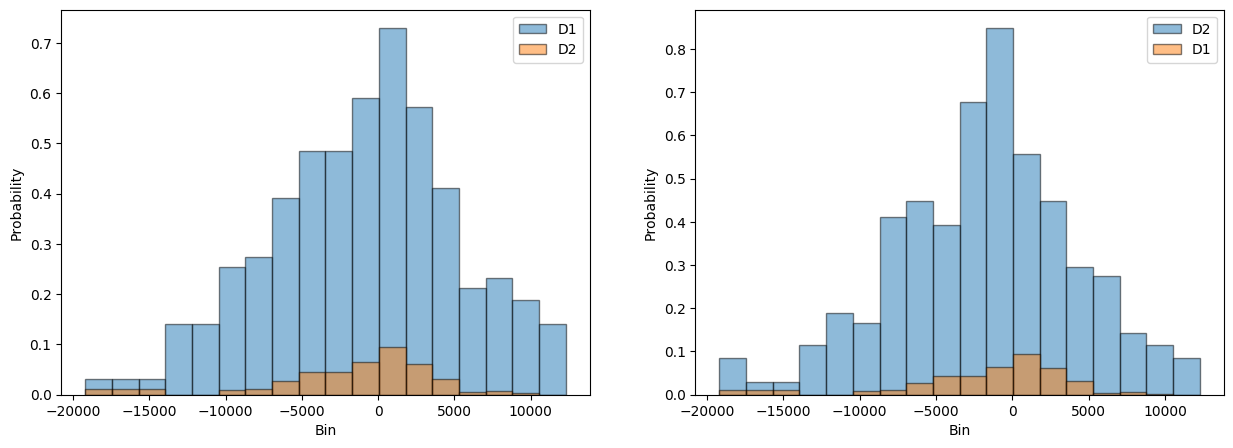

Testing:  1_1
Mean signed deviation ratio to actual:  -0.5821403271935189
p-Value of 1 sample t-test:  0.3058128827863567
DP Predicate Test Result:  True


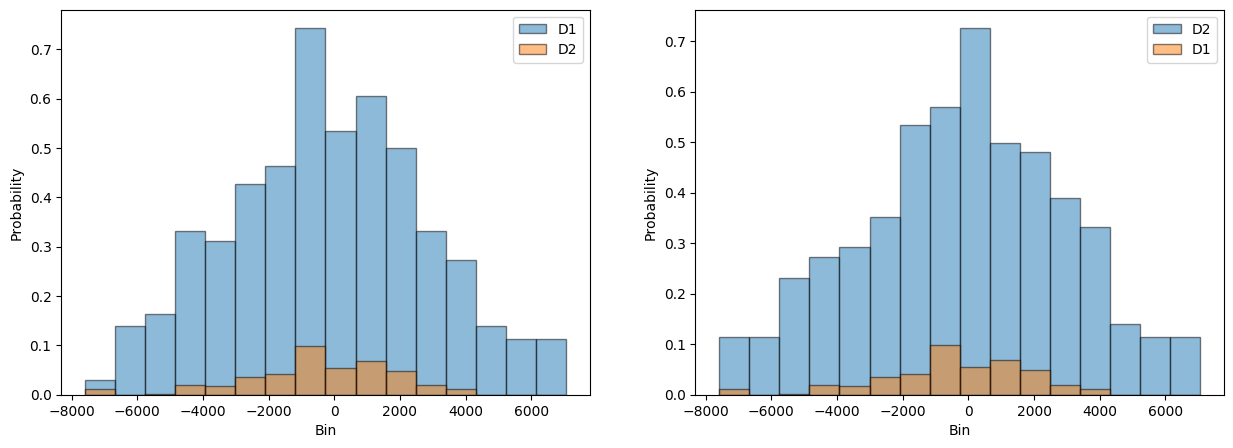

Testing:  012_1
Mean signed deviation ratio to actual:  -0.4069047908298421
p-Value of 1 sample t-test:  0.2996166602643854
DP Predicate Test Result:  True


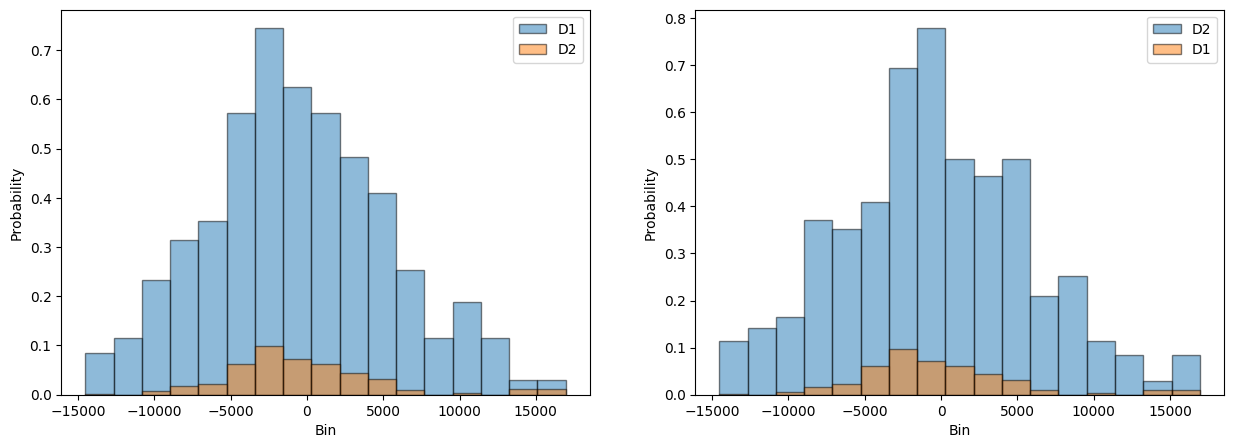

Testing:  02_0
Mean signed deviation ratio to actual:  0.3021792967626539
p-Value of 1 sample t-test:  0.6061121908721077
DP Predicate Test Result:  True


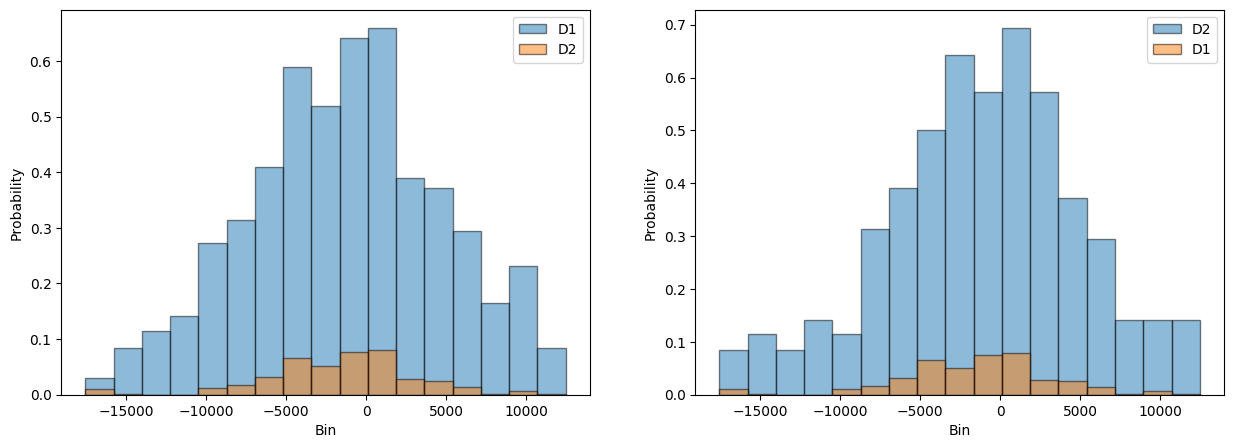

Testing:  02_2
Mean signed deviation ratio to actual:  -0.5611143370115397
p-Value of 1 sample t-test:  0.33845765262267224
DP Predicate Test Result:  True


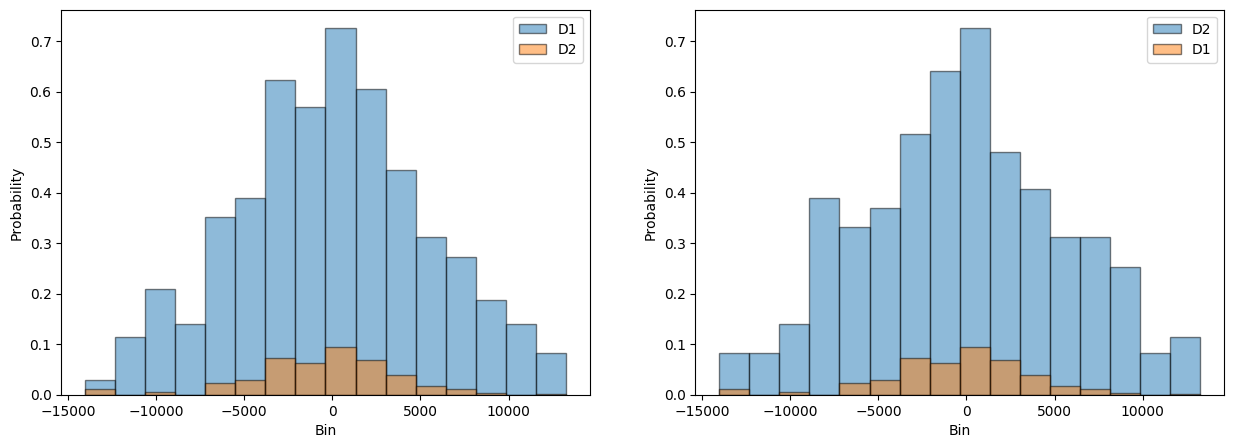

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


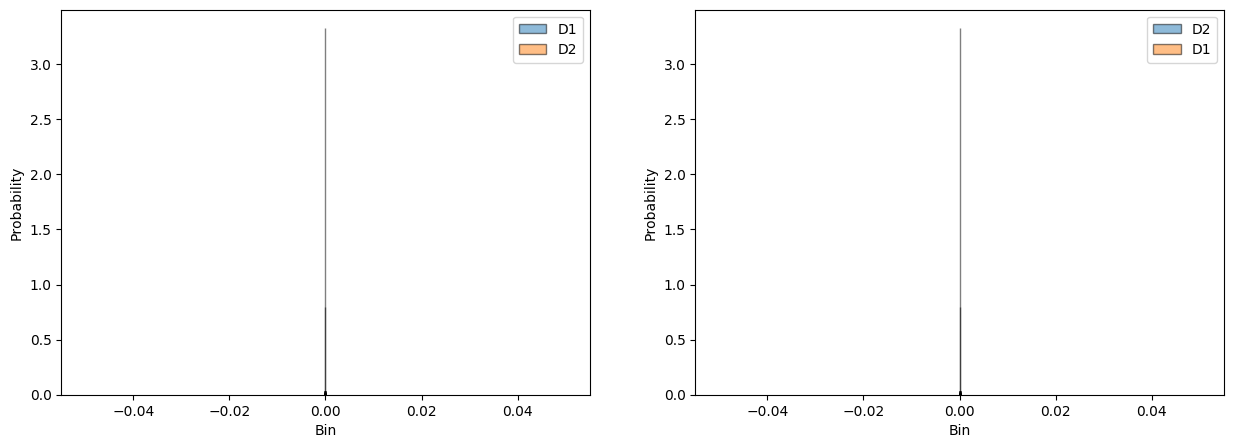

Testing:  012_2
Mean signed deviation ratio to actual:  0.4078092289566105
p-Value of 1 sample t-test:  0.2485626108563563
DP Predicate Test Result:  True


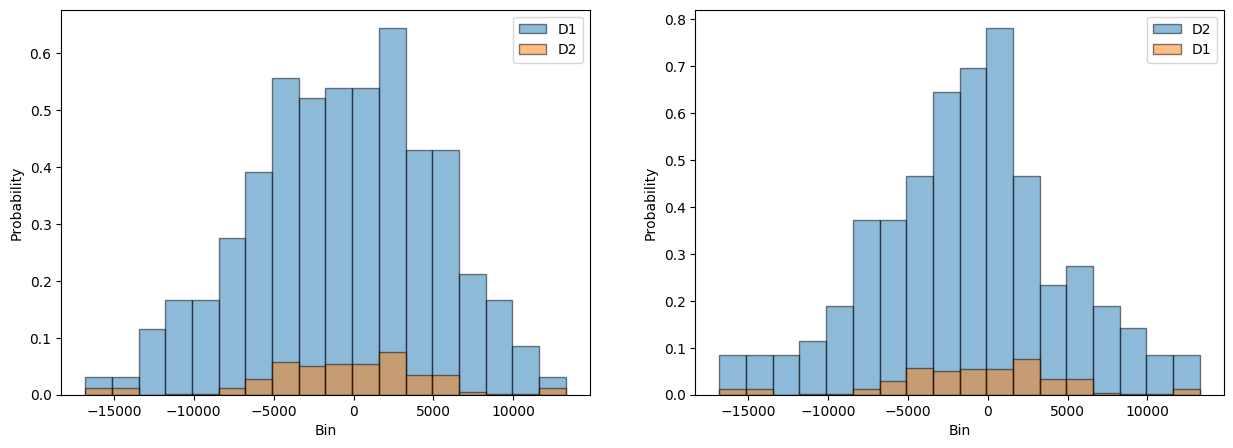

Testing:  01_0
Mean signed deviation ratio to actual:  0.7719907608272693
p-Value of 1 sample t-test:  0.19595600277108313
DP Predicate Test Result:  True


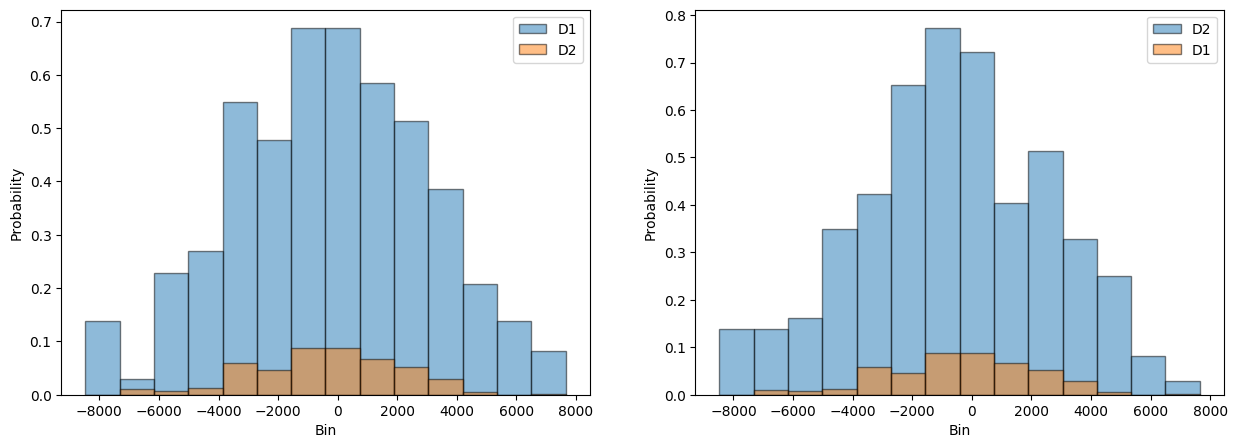

Testing:  01_1
Mean signed deviation ratio to actual:  -0.7139177138980095
p-Value of 1 sample t-test:  0.22223269035930046
DP Predicate Test Result:  True


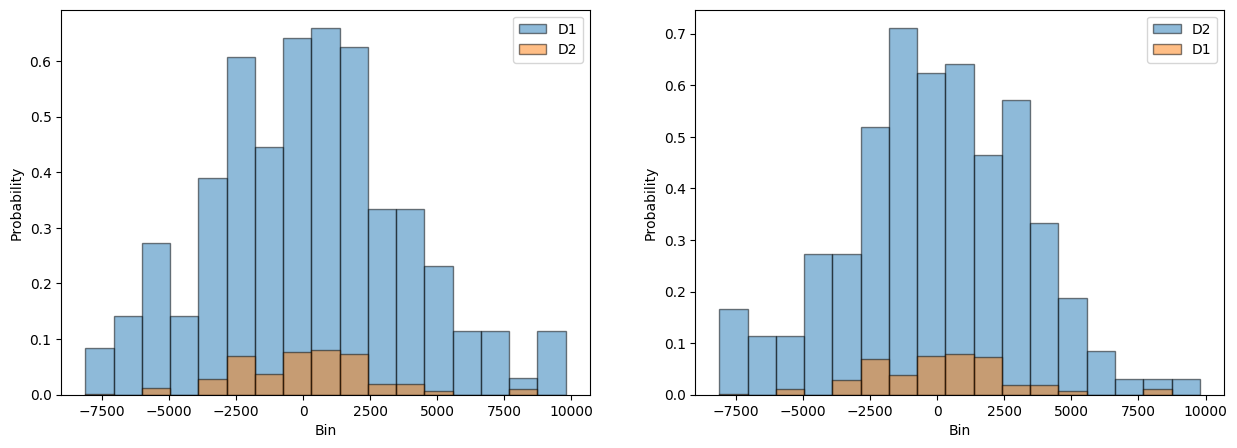

Test case:  [250.0, 555.5555555555554, -920.0]
Testing:  012_0
Mean signed deviation ratio to actual:  -1.1161796460086235
p-Value of 1 sample t-test:  0.002232819858934138
DP Predicate Test Result:  True


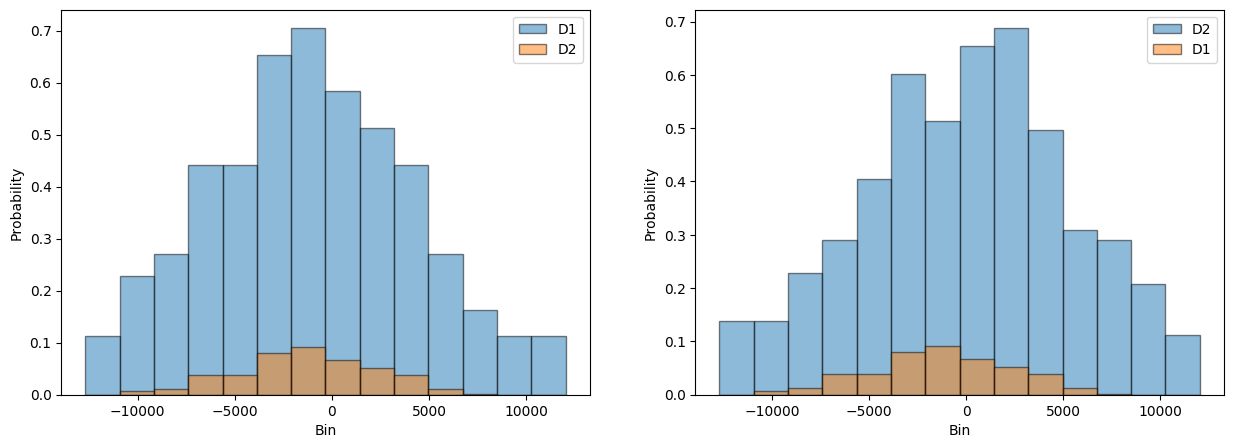

Testing:  12_1
Mean signed deviation ratio to actual:  0.26890971502232647
p-Value of 1 sample t-test:  0.4683897701175549
DP Predicate Test Result:  True


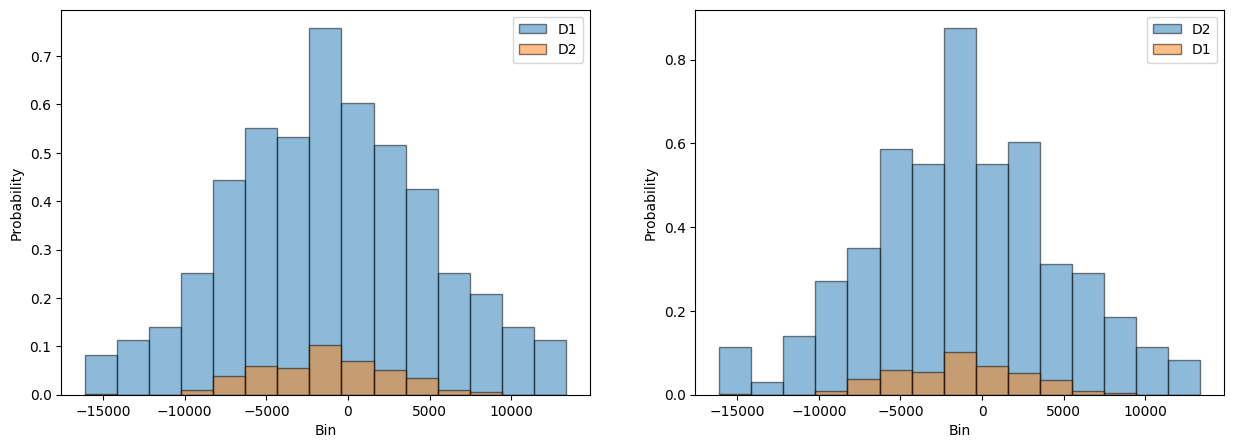

Testing:  2_2
Mean signed deviation ratio to actual:  -1.2687012951006789
p-Value of 1 sample t-test:  0.029428009867689026
DP Predicate Test Result:  True


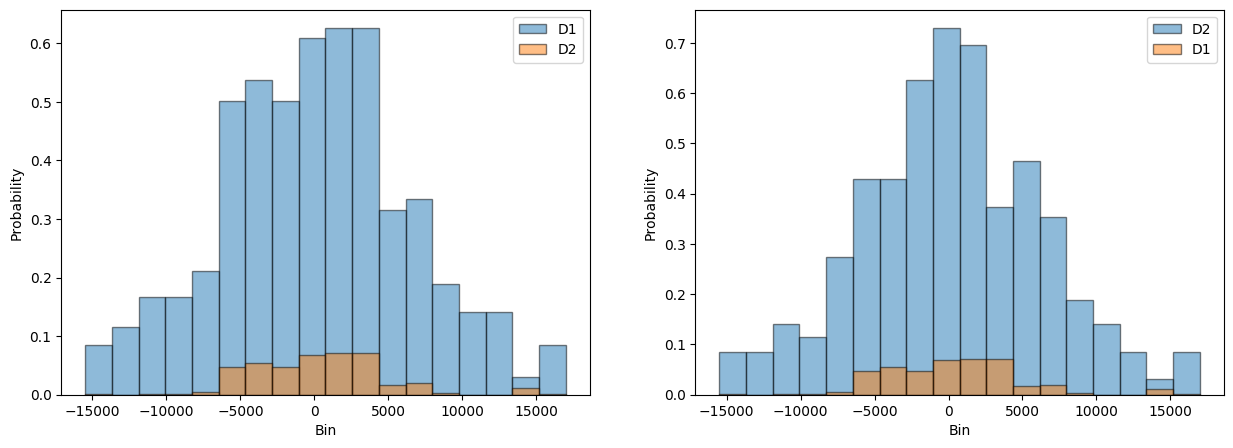

Testing:  12_2
Mean signed deviation ratio to actual:  -0.6773495905702489
p-Value of 1 sample t-test:  0.0629129930980743
DP Predicate Test Result:  True


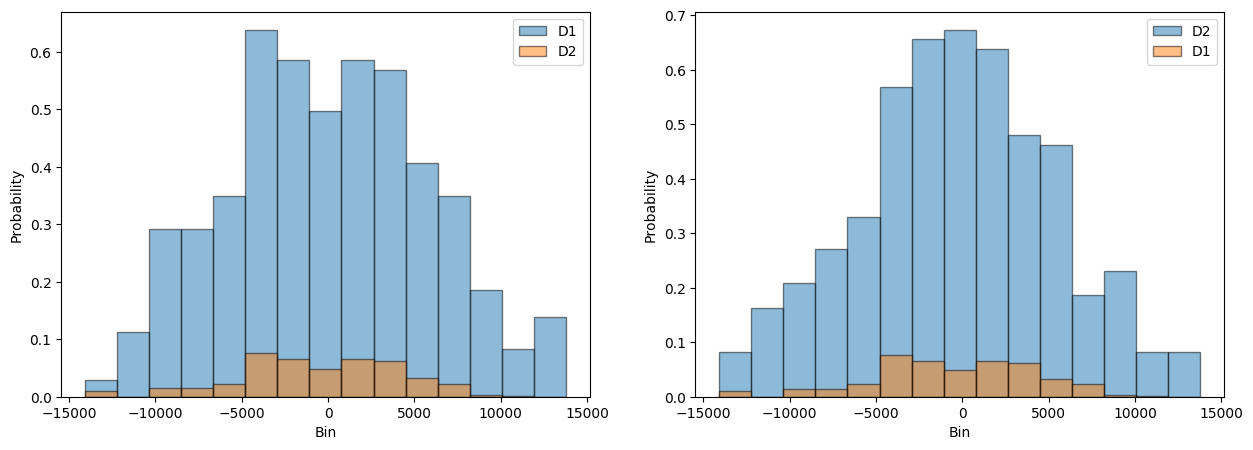

Testing:  1_1
Mean signed deviation ratio to actual:  -1.6376246943309136
p-Value of 1 sample t-test:  0.006022088298963147
DP Predicate Test Result:  True


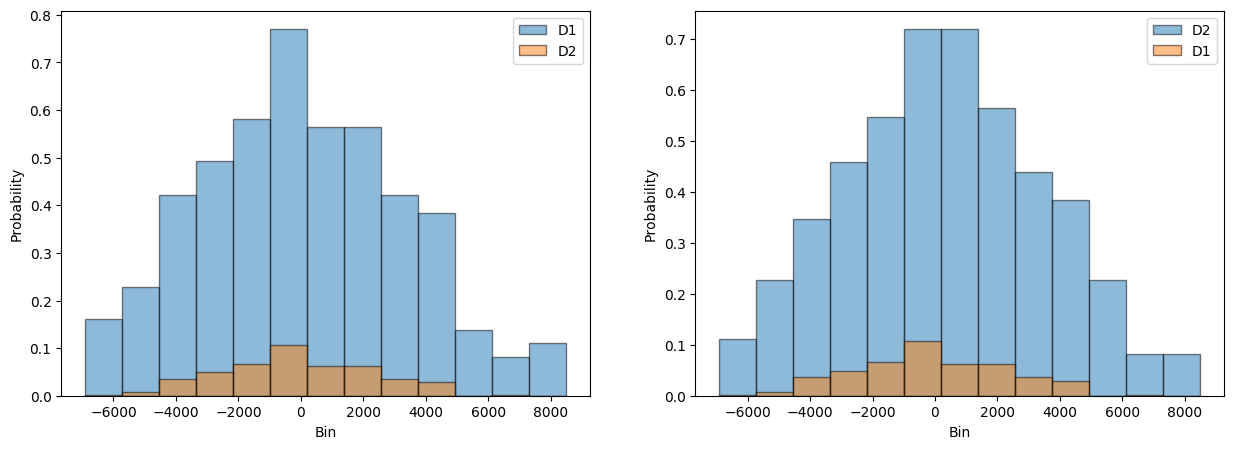

Testing:  012_1
Mean signed deviation ratio to actual:  -0.4456520821043657
p-Value of 1 sample t-test:  0.2440236428721118
DP Predicate Test Result:  True


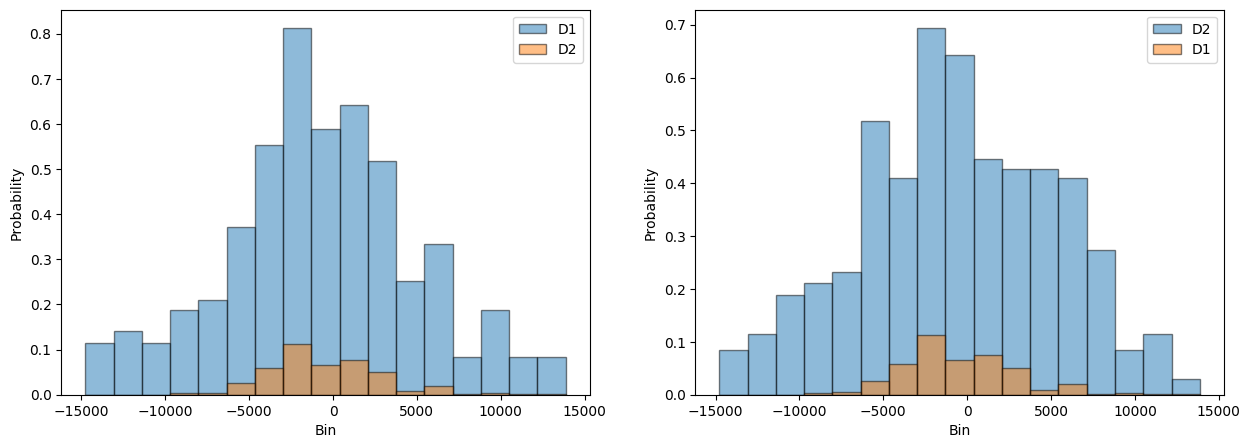

Testing:  02_0
Mean signed deviation ratio to actual:  0.42810635144382114
p-Value of 1 sample t-test:  0.46323501928752275
DP Predicate Test Result:  True


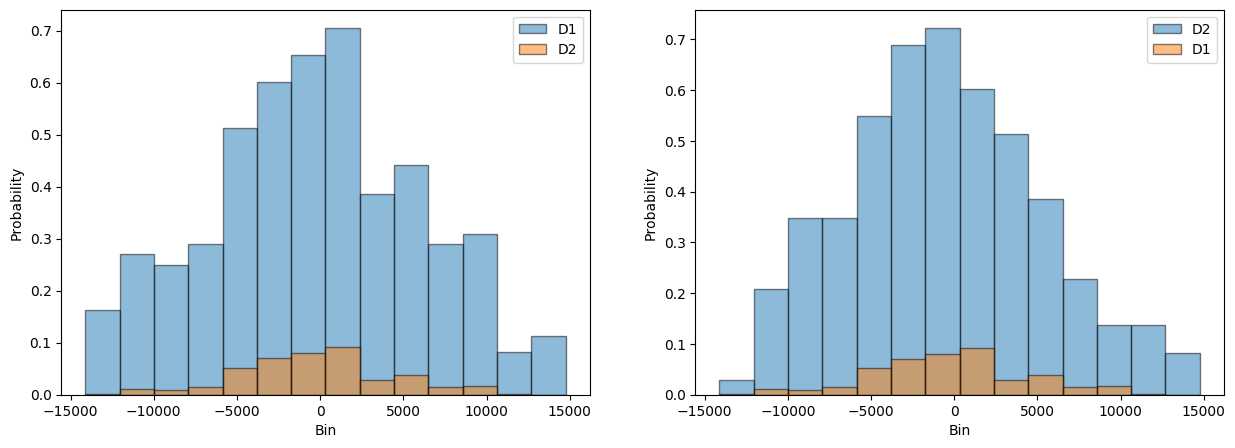

Testing:  02_2
Mean signed deviation ratio to actual:  0.6585544091477172
p-Value of 1 sample t-test:  0.25009827259726986
DP Predicate Test Result:  True


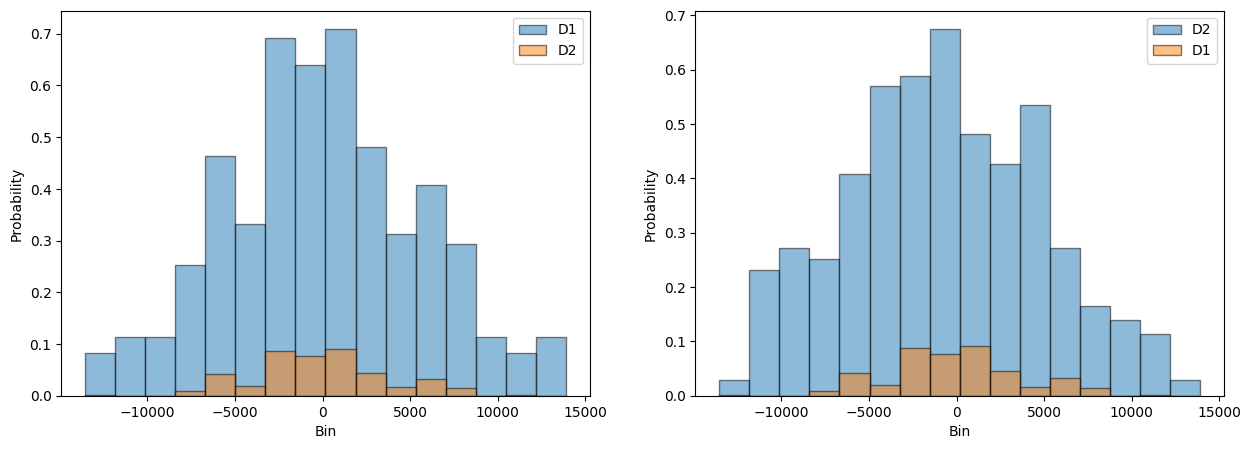

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


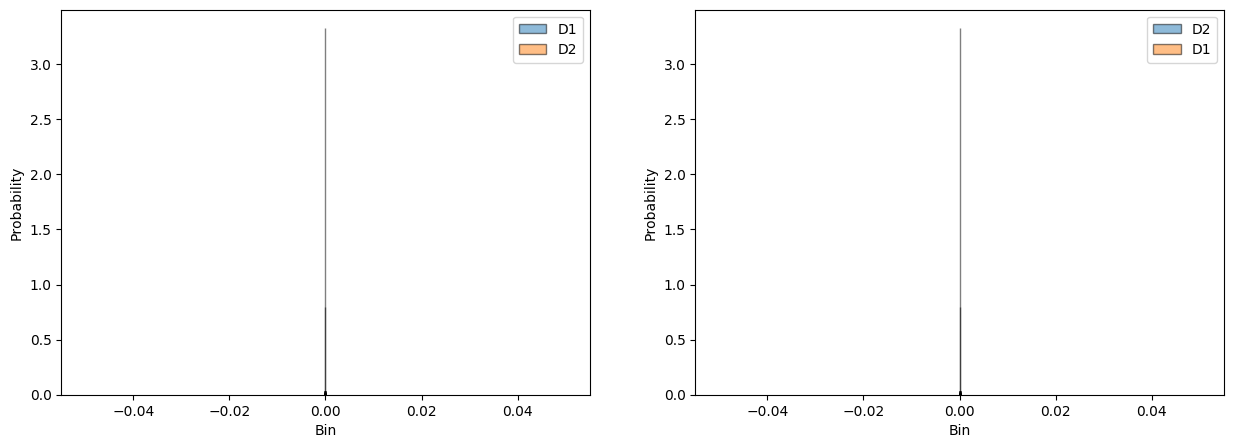

Testing:  012_2
Mean signed deviation ratio to actual:  -0.5350398512697928
p-Value of 1 sample t-test:  0.18533029224278674
DP Predicate Test Result:  True


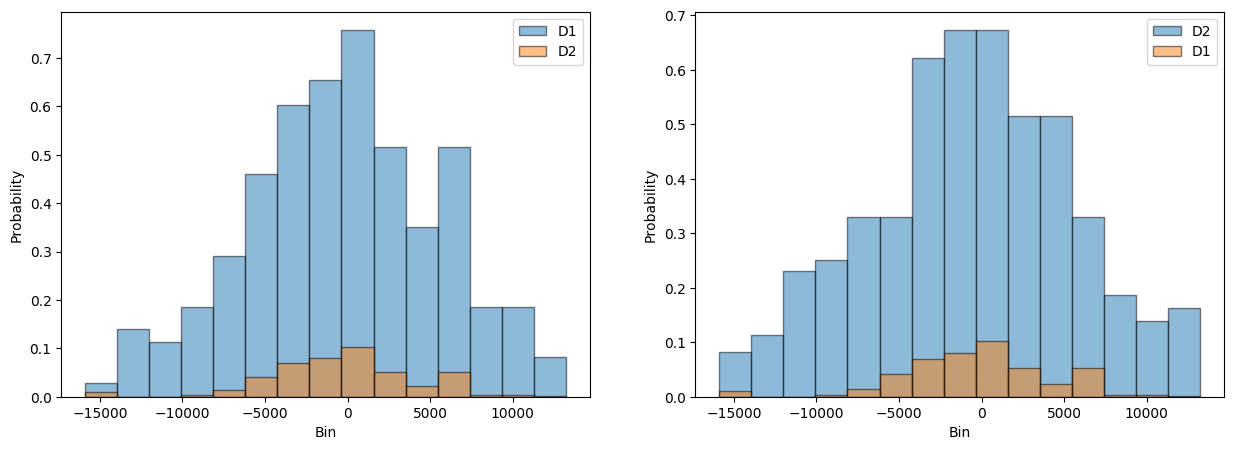

Testing:  01_0
Mean signed deviation ratio to actual:  0.21605974813424395
p-Value of 1 sample t-test:  0.7329543637230318
DP Predicate Test Result:  True


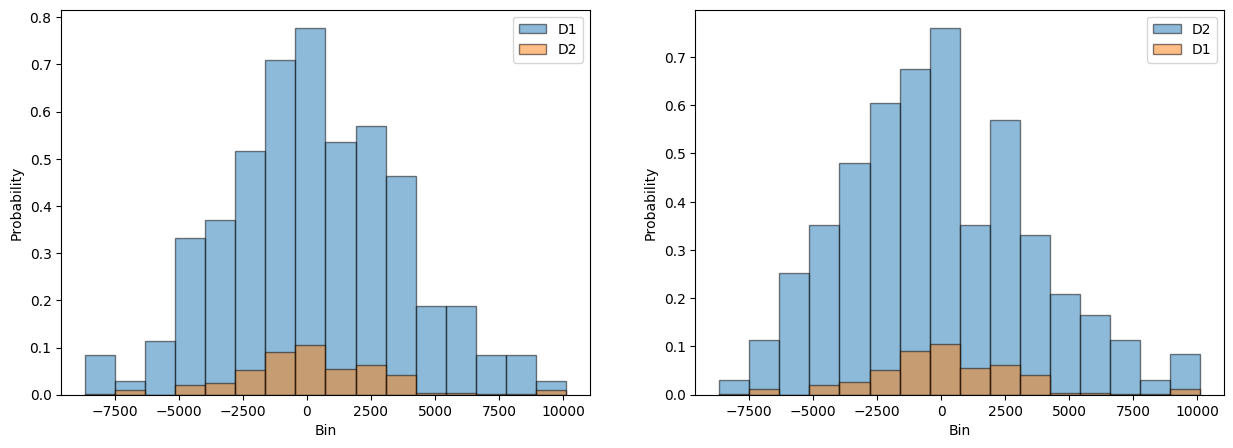

Testing:  01_1
Mean signed deviation ratio to actual:  -0.30778603325255455
p-Value of 1 sample t-test:  0.5821581048877427
DP Predicate Test Result:  True


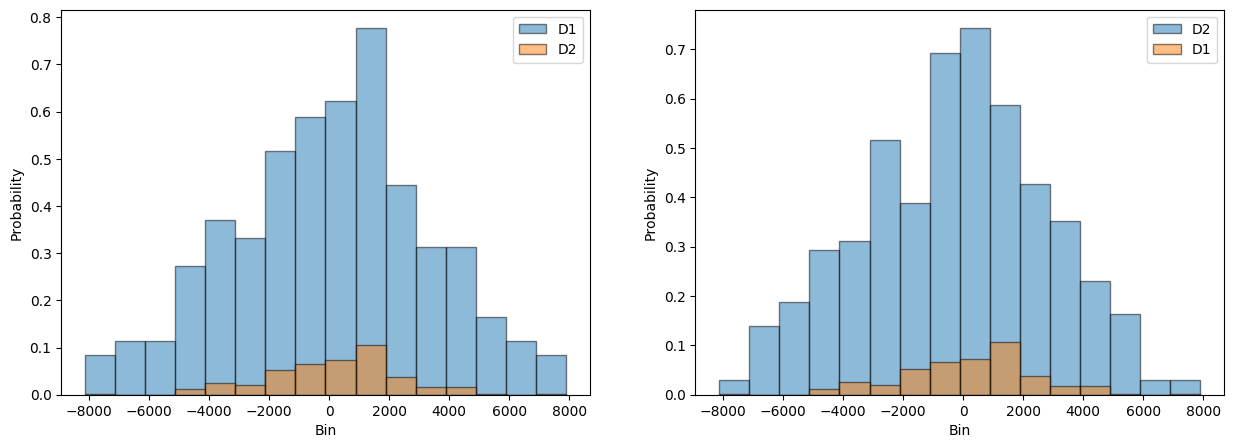

Halton sequence based Powerset Test Result
[0.0,-333.33333333333337,-600.0] - 012_0 - [True, None, None, None, False, 0.21566806054463078]
[0.0,-333.33333333333337,-600.0] - 12_1 - [True, None, None, None, False, -0.26251561627666165]
[0.0,-333.33333333333337,-600.0] - 2_2 - [True, None, None, None, False, -0.42414906390930845]
[0.0,-333.33333333333337,-600.0] - 12_2 - [True, None, None, None, False, 0.5668594730230889]
[0.0,-333.33333333333337,-600.0] - 1_1 - [True, None, None, None, True, -1.7401791674489753]
[0.0,-333.33333333333337,-600.0] - 012_1 - [True, None, None, None, False, 0.2588548374668051]
[0.0,-333.33333333333337,-600.0] - 02_0 - [True, None, None, None, False, -0.0018032214704960703]
[0.0,-333.33333333333337,-600.0] - 02_2 - [True, None, None, None, False, -0.33280910437226774]
[0.0,-333.33333333333337,-600.0] - 0_0 - [True, None, None, None, False, nan]
[0.0,-333.33333333333337,-600.0] - 012_2 - [True, None, None, None, False, -0.3615962942936705]
[0.0,-333.3333333333

In [26]:
start_time = time.time()
query_str = "SELECT SUM(Usage) AS TotalUsage FROM "
dp_res, acc_res, utility_res, bias_res = dv.dp_powerset_test(query_str, repeat_count=200, plot=True)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))